In [2]:
 %pip install duckdb
 %pip install polars

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/772.7 kB ? eta -:--:--
   ------------- -------------------------- 262.1/772.7 kB ? eta -:--:--
   --------------------------- ------------ 524.3/772.7 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 772.7/772.7 kB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.1 MB ? eta -:--:--
    --------------------------------------- 0.5/40.1 MB 1.7 MB/s eta 0:00:24
   - -------------------------------------- 1.6/40.1 MB 3.5 MB/s eta 0:00:12
   -- ------------------------------------- 2.9/40.1 MB 4.5 MB/s eta 0:00:09
   ----- ---------------------------------- 5.2/40.1 MB 6.2 MB/s eta 0:00:06
   --------- --------------------------

Data setup and performance foundations
Efficient I/O and caching
- Remote parquet scanning: Use DuckDB‚Äôs parquet_scan to query remote files with predicate and projection pushdown.
- HTTP caching: Enable DuckDB‚Äôs HTTPFS for caching remote parquet locally to accelerate iterative work.


In [84]:
import duckdb, polars as pl

con = duckdb.connect()
con.execute("INSTALL httpfs; LOAD httpfs;")
con.execute("SET enable_object_cache=true;")

# Links diretos (RAW do GitHub)
files = {
    "ratings": "https://github.com/Matheuskcode/Data-Found-Project/raw/main/Data/ratings.parquet",
    "movies":  "https://github.com/Matheuskcode/Data-Found-Project/raw/main/Data/movies.parquet",
    "tags":    "https://github.com/Matheuskcode/Data-Found-Project/raw/main/Data/tags.parquet"
}

# Criar views
con.execute(f"CREATE OR REPLACE VIEW ratings AS SELECT * FROM parquet_scan('{files['ratings']}')")
con.execute(f"CREATE OR REPLACE VIEW movies  AS SELECT * FROM parquet_scan('{files['movies']}')")
con.execute(f"CREATE OR REPLACE VIEW tags    AS SELECT * FROM parquet_scan('{files['tags']}')")

In [52]:
# 1) Distribui√ß√£o de notas
stat1_ratings_dist = q("""
    SELECT rating::DOUBLE AS rating, COUNT(*) AS freq
    FROM ratings
    GROUP BY rating
    ORDER BY rating
""")

# 2) Top 10 filmes mais avaliados
stat2_most_rated = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings, AVG(r.rating) AS avg_rating
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    ORDER BY n_ratings DESC
    LIMIT 10
""")

# 3) Top 10 filmes com melhor m√©dia (‚â•100 avalia√ß√µes)
stat3_best_rated_100 = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings, AVG(r.rating) AS avg_rating
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 100
    ORDER BY avg_rating DESC
    LIMIT 10
""")

# 4) Popularidade por g√™nero
stat4_genre_pop = q("""
    WITH exploded AS (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    )
    SELECT genre, COUNT(*) AS n_movies
    FROM exploded
    GROUP BY genre
    ORDER BY n_movies DESC
""")

# 5) Atividade de avalia√ß√µes ao longo do tempo (mensal)
stat5_ratings_by_month = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(*) AS n_ratings,
           AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY month
    ORDER BY month
""")

# 6) Ciclo de vida por ano de lan√ßamento
stat6_by_year = q("""
    SELECT CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) AS year_guess,
           COUNT(r.rating) AS n_ratings,
           AVG(r.rating) AS avg_rating
    FROM movies m
    LEFT JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(%)'
      AND TRY_CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) IS NOT NULL
    GROUP BY year_guess
    ORDER BY year_guess
""")

# 7) Atividade por filme
stat7_movie_activity = q("""
    SELECT movieId, COUNT(*) AS n_ratings, AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY movieId
    ORDER BY n_ratings DESC
""")

# 8) Tags mais frequentes
stat8_tags_freq = q("""
    SELECT LOWER(TRIM(tag)) AS tag, COUNT(*) AS freq
    FROM tags
    WHERE tag IS NOT NULL AND TRIM(tag) <> ''
    GROUP BY LOWER(TRIM(tag))
    ORDER BY freq DESC
    LIMIT 20
""")

# 9) Co-ocorr√™ncia de g√™neros
stat9_genre_pairs = q("""
    WITH exploded AS (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    ),
    pairs AS (
        SELECT a.movieId, LEAST(a.genre,b.genre) AS g1, GREATEST(a.genre,b.genre) AS g2
        FROM exploded a
        JOIN exploded b ON a.movieId = b.movieId AND a.genre < b.genre
    )
    SELECT g1, g2, COUNT(*) AS n
    FROM pairs
    GROUP BY g1, g2
    ORDER BY n DESC
    LIMIT 20
""")

# 10) M√©dia global
stat10_global_mean = q("SELECT AVG(rating) AS gmean FROM ratings")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [53]:
print("\n=== 1) Distribui√ß√£o de notas ===")
print(stat1_ratings_dist)

print("\n=== 2) Top 10 filmes mais avaliados ===")
print(stat2_most_rated)

print("\n=== 3) Top 10 filmes com melhor m√©dia (‚â•100 avalia√ß√µes) ===")
print(stat3_best_rated_100)

print("\n=== 4) Popularidade por g√™nero ===")
print(stat4_genre_pop)

print("\n=== 5) Atividade de avalia√ß√µes ao longo do tempo (mensal) ===")
print(stat5_ratings_by_month.head(15))

print("\n=== 6) Ciclo de vida por ano de lan√ßamento ===")
print(stat6_by_year)

print("\n=== 7) Atividade por filme (long tail) ===")
print(stat7_movie_activity.head(20))

print("\n=== 8) Tags mais frequentes ===")
print(stat8_tags_freq)

print("\n=== 9) Co-ocorr√™ncia de g√™neros ===")
print(stat9_genre_pairs)

print("\n=== 10) M√©dia global de todas as avalia√ß√µes ===")
print(stat10_global_mean)


=== 1) Distribui√ß√£o de notas ===
shape: (10, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rating ‚îÜ freq    ‚îÇ
‚îÇ ---    ‚îÜ ---     ‚îÇ
‚îÇ f64    ‚îÜ i64     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0.5    ‚îÜ 94988   ‚îÇ
‚îÇ 1.0    ‚îÜ 384180  ‚îÇ
‚îÇ 1.5    ‚îÜ 118278  ‚îÇ
‚îÇ 2.0    ‚îÜ 790306  ‚îÇ
‚îÇ 2.5    ‚îÜ 370178  ‚îÇ
‚îÇ 3.0    ‚îÜ 2356676 ‚îÇ
‚îÇ 3.5    ‚îÜ 879764  ‚îÇ
‚îÇ 4.0    ‚îÜ 2875850 ‚îÇ
‚îÇ 4.5    ‚îÜ 585022  ‚îÇ
‚îÇ 5.0    ‚îÜ 1544812 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

=== 2) Top 10 filmes mais avaliados ===
shape: (10, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n_ratings ‚îÜ avg_rating ‚îÇ
‚îÇ ---                             ‚îÜ ---       ‚îÜ ---        ‚îÇ
‚îÇ str                             ‚îÜ 

In [54]:
# 11) Distribui√ß√£o de n¬∫ de avalia√ß√µes por usu√°rio
stat11_user_activity = q("""
    SELECT userId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY userId
""")

# 12) Distribui√ß√£o da m√©dia de notas por usu√°rio
stat12_user_avg = q("""
    SELECT userId, AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY userId
""")

# 13) Top 20 usu√°rios mais ativos
stat13_user_top20 = q("""
    SELECT userId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY userId
    ORDER BY n_ratings DESC
    LIMIT 20
""")

# 14) Notas por g√™nero
stat14_ratings_genre = q("""
    WITH exploded AS (
        SELECT r.rating, UNNEST(STRING_SPLIT(m.genres, '|')) AS genre
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    )
    SELECT genre, rating
    FROM exploded
""")

# 15) Usu√°rios √∫nicos por m√™s
stat15_users_month = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(DISTINCT userId) AS n_users
    FROM ratings
    GROUP BY month
    ORDER BY month
""")

# 16) Filmes distintos avaliados por m√™s
stat16_movies_month = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(DISTINCT movieId) AS n_movies
    FROM ratings
    GROUP BY month
    ORDER BY month
""")

# 17) Rela√ß√£o n¬∫ de avalia√ß√µes x m√©dia do filme
stat17_movie_activity = q("""
    SELECT movieId, COUNT(*) AS n_ratings, AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY movieId
    ORDER BY n_ratings DESC
""")

# 18) Distribui√ß√£o de avalia√ß√µes por hora
stat18_ratings_hour = q("""
    SELECT EXTRACT('hour' FROM TO_TIMESTAMP(timestamp)) AS hour,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY hour
    ORDER BY hour
""")

# 19) Distribui√ß√£o de avalia√ß√µes por dia da semana
stat19_ratings_weekday = q("""
    SELECT EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) AS dow,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY dow
    ORDER BY dow
""")

# 20) Filmes mais polarizadores
stat20_polarizing = q("""
    SELECT m.title, COUNT(*) AS n, STDDEV(rating) AS std
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 500
    ORDER BY std DESC
    LIMIT 15
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [55]:
print("\n=== 11) Distribui√ß√£o de n¬∫ de avalia√ß√µes por usu√°rio ===")
print(stat11_user_activity.describe())

print("\n=== 12) Distribui√ß√£o da m√©dia de notas por usu√°rio ===")
print(stat12_user_avg.describe())

print("\n=== 13) Top 20 usu√°rios mais ativos ===")
print(stat13_user_top20)

print("\n=== 14) Notas por g√™nero (amostra) ===")
print(stat14_ratings_genre.head(20))

print("\n=== 15) Usu√°rios √∫nicos por m√™s (primeiros 12 meses) ===")
print(stat15_users_month.head(12))

print("\n=== 16) Filmes distintos avaliados por m√™s (primeiros 12 meses) ===")
print(stat16_movies_month.head(12))

print("\n=== 17) Rela√ß√£o n¬∫ de avalia√ß√µes x m√©dia do filme (top 20) ===")
print(stat17_movie_activity.head(20))

print("\n=== 18) Distribui√ß√£o de avalia√ß√µes por hora ===")
print(stat18_ratings_hour)

print("\n=== 19) Distribui√ß√£o de avalia√ß√µes por dia da semana ===")
print(stat19_ratings_weekday)

print("\n=== 20) Filmes mais polarizadores ===")
print(stat20_polarizing)


=== 11) Distribui√ß√£o de n¬∫ de avalia√ß√µes por usu√°rio ===
shape: (9, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ userId       ‚îÜ n_ratings ‚îÇ
‚îÇ ---        ‚îÜ ---          ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ f64          ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 69878.0      ‚îÜ 69878.0   ‚îÇ
‚îÇ null_count ‚îÜ 0.0          ‚îÜ 0.0       ‚îÇ
‚îÇ mean       ‚îÜ 35782.217393 ‚îÜ 143.10733 ‚îÇ
‚îÇ std        ‚îÜ 20613.909098 ‚îÜ 216.71258 ‚îÇ
‚îÇ min        ‚îÜ 1.0          ‚îÜ 20.0      ‚îÇ
‚îÇ 25%        ‚îÜ 17943.0      ‚îÜ 35.0      ‚îÇ
‚îÇ 50%        ‚îÜ 35799.0      ‚îÜ 69.0      ‚îÇ
‚îÇ 75%        ‚îÜ 53620.0      ‚îÜ 156.0     ‚îÇ
‚îÇ max        ‚îÜ 71567.0      ‚îÜ 7359.0    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

In [56]:
# 21) Filmes mais consensuais
stat21_consensus = q("""
    SELECT m.title, COUNT(*) AS n, STDDEV(r.rating) AS std
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 500
    ORDER BY std ASC
    LIMIT 15
""")

# 22) N¬∫ de tags por usu√°rio
stat22_tags_user = q("""
    SELECT userId, COUNT(*) AS n_tags
    FROM tags
    GROUP BY userId
""")

# 23) Tags mais associadas a notas altas
stat23_tags_high = q("""
    SELECT LOWER(TRIM(t.tag)) AS tag, COUNT(*) AS freq
    FROM tags t
    JOIN ratings r USING (movieId)
    WHERE r.rating >= 4
    GROUP BY LOWER(TRIM(t.tag))
    ORDER BY freq DESC
    LIMIT 20
""")

# 24) Tags mais associadas a notas baixas
stat24_tags_low = q("""
    SELECT LOWER(TRIM(t.tag)) AS tag, COUNT(*) AS freq
    FROM tags t
    JOIN ratings r USING (movieId)
    WHERE r.rating <= 2
    GROUP BY LOWER(TRIM(t.tag))
    ORDER BY freq DESC
    LIMIT 20
""")

# 25) Evolu√ß√£o da nota m√©dia por g√™nero ao longo do tempo
stat25_genre_time = q("""
    WITH exploded AS (
        SELECT r.rating,
               TO_TIMESTAMP(r.timestamp) AS ts,
               UNNEST(STRING_SPLIT(m.genres, '|')) AS genre
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    )
    SELECT DATE_TRUNC('year', ts) AS year,
           genre,
           AVG(rating) AS avg_rating,
           COUNT(*) AS n
    FROM exploded
    GROUP BY year, genre
    HAVING COUNT(*) >= 500
    ORDER BY year
""")

# 26) Cl√°ssicos antigos (antes de 1960)
stat26_old_classics = q("""
    SELECT m.title, AVG(r.rating) AS avg_rating, COUNT(*) AS n
    FROM movies m
    JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(19%'
      AND CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) < 1960
    GROUP BY m.title
    HAVING COUNT(*) >= 200
    ORDER BY avg_rating DESC
    LIMIT 15
""")

# 27) Filmes recentes (2000+)
stat27_recent_movies = q("""
    SELECT m.title, AVG(r.rating) AS avg_rating, COUNT(*) AS n
    FROM movies m
    JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(20%'
    GROUP BY m.title
    HAVING COUNT(*) >= 500
    ORDER BY avg_rating DESC
    LIMIT 15
""")

# 28) Nota m√©dia por d√©cada
stat28_decades = q("""
    SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
           AVG(r.rating) AS avg_rating,
           COUNT(*) AS n
    FROM movies m
    JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(%)'
    GROUP BY decade
    ORDER BY decade
""")

# 29) N¬∫ de g√™neros por filme
stat29_genres_count = q("""
    SELECT movieId, COUNT(*) AS n_genres
    FROM (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS g
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    )
    GROUP BY movieId
""")

# 30) Filmes com mais g√™neros
stat30_hybrid_movies = q("""
    SELECT m.title, COUNT(*) AS n_genres
    FROM movies m, UNNEST(STRING_SPLIT(m.genres, '|')) g
    WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    GROUP BY m.title
    ORDER BY n_genres DESC
    LIMIT 15
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [58]:
print("\n=== 21) Filmes mais consensuais ===")
print(stat21_consensus)

print("\n=== 22) N¬∫ de tags por usu√°rio (estat√≠sticas) ===")
print(stat22_tags_user.describe())

print("\n=== 23) Tags mais associadas a notas altas ===")
print(stat23_tags_high)

print("\n=== 24) Tags mais associadas a notas baixas ===")
print(stat24_tags_low)

print("\n=== 25) Evolu√ß√£o da nota m√©dia por g√™nero (amostra) ===")
print(stat25_genre_time.head(20))

print("\n=== 26) Cl√°ssicos antigos mais bem avaliados ===")
print(stat26_old_classics)

print("\n=== 27) Filmes recentes mais bem avaliados ===")
print(stat27_recent_movies)

print("\n=== 28) Nota m√©dia por d√©cada ===")
print(stat28_decades)

print("\n=== 29) N¬∫ de g√™neros por filme (estat√≠sticas) ===")
print(stat29_genres_count.describe())

print("\n=== 30) Filmes com mais g√™neros ===")
print(stat30_hybrid_movies)


=== 21) Filmes mais consensuais ===
shape: (15, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n    ‚îÜ std      ‚îÇ
‚îÇ ---                             ‚îÜ ---  ‚îÜ ---      ‚îÇ
‚îÇ str                             ‚îÜ i64  ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Gone Baby Gone (2007)           ‚îÜ 734  ‚îÜ 0.641226 ‚îÇ
‚îÇ Last King of Scotland, The (20‚Ä¶ ‚îÜ 1281 ‚îÜ 0.644991 ‚îÇ
‚îÇ Touching the Void (2003)        ‚îÜ 888  ‚îÜ 0.65028  ‚îÇ
‚îÇ Bank Job, The (2008)            ‚îÜ 605  ‚îÜ 0.657802 ‚îÇ
‚îÇ Murder on the Orient Express (‚Ä¶ ‚îÜ 538  ‚îÜ 0.664082 ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶    ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ Good bye, Lenin! (2003)         ‚îÜ 1662 ‚îÜ 0.672287 ‚î

In [69]:
# 31) Distribui√ß√£o de notas por d√©cada
stat31 = q("""
    SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
           rating, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE m.title LIKE '%(%)'
    GROUP BY decade, rating
    ORDER BY decade, rating
""")

# 32) Filmes mais avaliados em cada d√©cada
stat32 = q("""
    SELECT decade, title, n_ratings
    FROM (
        SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
               m.title, COUNT(r.rating) AS n_ratings,
               ROW_NUMBER() OVER (
                   PARTITION BY (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10
                   ORDER BY COUNT(r.rating) DESC
               ) AS rk
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.title LIKE '%(%)'
        GROUP BY decade, m.title
    ) t
    WHERE rk = 1
""")

# 33) Filmes com maior propor√ß√£o de notas 5
stat33 = q("""
    SELECT m.title,
           COUNT(*) FILTER (WHERE r.rating=5.0)*1.0/COUNT(*) AS prop_5,
           COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 200
    ORDER BY prop_5 DESC
    LIMIT 20
""")

# 34) Filmes com maior propor√ß√£o de notas 0.5
stat34 = q("""
    SELECT m.title,
           COUNT(*) FILTER (WHERE r.rating=0.5)*1.0/COUNT(*) AS prop_05,
           COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 200
    ORDER BY prop_05 DESC
    LIMIT 20
""")

# 35) Usu√°rios que mais usam notas extremas
stat35 = q("""
    SELECT userId,
           COUNT(*) FILTER (WHERE rating=0.5 OR rating=5.0)*1.0/COUNT(*) AS prop_extremas,
           COUNT(*) AS n
    FROM ratings
    GROUP BY userId
    HAVING COUNT(*) >= 100
    ORDER BY prop_extremas DESC
    LIMIT 20
""")

# 36) Heatmap hora x dia da semana
stat36 = q("""
    SELECT EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) AS dow,
           EXTRACT('hour' FROM TO_TIMESTAMP(timestamp)) AS hour,
           COUNT(*) AS n
    FROM ratings
    GROUP BY dow, hour
    ORDER BY dow, hour
""")

# 37) Filmes mais tagueados
stat37 = q("""
    SELECT m.title, COUNT(t.tag) AS n_tags
    FROM tags t
    JOIN movies m USING (movieId)
    GROUP BY m.title
    ORDER BY n_tags DESC
    LIMIT 20
""")

# 38) Tags mais populares por d√©cada
stat38 = q("""
    SELECT decade, tag, n
    FROM (
        SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
               LOWER(TRIM(tag)) AS tag, COUNT(*) AS n,
               ROW_NUMBER() OVER (
                   PARTITION BY (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10
                   ORDER BY COUNT(*) DESC
               ) AS rk
        FROM tags t
        JOIN movies m USING (movieId)
        WHERE m.title LIKE '%(%)'
        GROUP BY decade, tag
    ) q
    WHERE rk <= 5
""")

# 39) Filmes com maior varia√ß√£o de notas ao longo do tempo
stat39 = q("""
    SELECT m.title, STDDEV(avg_rating) AS std_time, COUNT(*) AS n_periods
    FROM (
        SELECT movieId, DATE_TRUNC('year', TO_TIMESTAMP(timestamp)) AS ano, AVG(rating) AS avg_rating
        FROM ratings
        GROUP BY movieId, ano
    ) sub
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 5
    ORDER BY std_time DESC
    LIMIT 20
""")

# 40) Evolu√ß√£o da quantidade de tags ao longo do tempo
stat40 = q("""
    SELECT DATE_TRUNC('year', TO_TIMESTAMP(timestamp)) AS ano, COUNT(*) AS n_tags
    FROM tags
    GROUP BY ano
    ORDER BY ano
""")

# 41) Filmes mais avaliados por novatos (‚â§10 avalia√ß√µes)
stat41 = q("""
    SELECT m.title, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE r.userId IN (
        SELECT userId FROM ratings GROUP BY userId HAVING COUNT(*) <= 10
    )
    GROUP BY m.title
    ORDER BY n DESC
    LIMIT 20
""")

# 42) Filmes mais avaliados por veteranos (‚â•1000 avalia√ß√µes)
stat42 = q("""
    SELECT m.title, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE r.userId IN (
        SELECT userId FROM ratings GROUP BY userId HAVING COUNT(*) >= 1000
    )
    GROUP BY m.title
    ORDER BY n DESC
    LIMIT 20
""")

# 43) Diferen√ßa de m√©dia entre novatos e veteranos
stat43 = q("""
    WITH novatos AS (
        SELECT movieId, AVG(rating) AS avg_nov
        FROM ratings
        WHERE userId IN (SELECT userId FROM ratings GROUP BY userId HAVING COUNT(*) <= 10)
        GROUP BY movieId
    ),
    veteranos AS (
        SELECT movieId, AVG(rating) AS avg_vet
        FROM ratings
        WHERE userId IN (SELECT userId FROM ratings GROUP BY userId HAVING COUNT(*) >= 1000)
        GROUP BY movieId
    )
    SELECT m.title, avg_nov, avg_vet, (avg_vet-avg_nov) AS diff
    FROM movies m
    JOIN novatos n USING (movieId)
    JOIN veteranos v USING (movieId)
    WHERE (SELECT COUNT(*) FROM ratings r WHERE r.movieId=m.movieId) >= 500
    ORDER BY ABS(diff) DESC
    LIMIT 20
""")

# 44) Filmes mais avaliados em finais de semana
stat44 = q("""
    SELECT m.title, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) IN (0,6)
    GROUP BY m.title
    ORDER BY n DESC
    LIMIT 20
""")

# 45) Filmes mais avaliados em dias √∫teis
stat45 = q("""
    SELECT m.title, COUNT(*) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) BETWEEN 1 AND 5
    GROUP BY m.title
    ORDER BY n DESC
    LIMIT 20
""")

# 46) Diferen√ßa de m√©dia semana vs fim de semana
stat46 = q("""
    WITH semana AS (
        SELECT movieId, AVG(rating) AS avg_semana
        FROM ratings
        WHERE EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) BETWEEN 1 AND 5
        GROUP BY movieId
    ),
    fimsemana AS (
        SELECT movieId, AVG(rating) AS avg_fds
        FROM ratings
        WHERE EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) IN (0,6)
        GROUP BY movieId
    )
    SELECT m.title, avg_semana, avg_fds, (avg_fds-avg_semana) AS diff
    FROM movies m
    JOIN semana s USING (movieId)
    JOIN fimsemana f USING (movieId)
    WHERE (SELECT COUNT(*) FROM ratings r WHERE r.movieId=m.movieId) >= 500
    ORDER BY ABS(diff) DESC
    LIMIT 20
""")

# 47) Filmes com maior crescimento de avalia√ß√µes ao longo dos anos
stat47 = q("""
    SELECT m.title, MAX(n)-MIN(n) AS crescimento
    FROM (
        SELECT movieId, DATE_TRUNC('year', TO_TIMESTAMP(timestamp)) AS ano, COUNT(*) AS n
        FROM ratings
        GROUP BY movieId, ano
    ) sub
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 5
    ORDER BY crescimento DESC
    LIMIT 20
""")

# 48) Filmes com maior queda de popularidade (redu√ß√£o de avalia√ß√µes ao longo dos anos)
stat48 = q("""
    SELECT m.title, MIN(n) - MAX(n) AS queda
    FROM (
        SELECT movieId,
               DATE_TRUNC('year', TO_TIMESTAMP(timestamp)) AS ano,
               COUNT(*) AS n
        FROM ratings
        GROUP BY movieId, ano
    ) sub
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(*) >= 5
    ORDER BY queda ASC
    LIMIT 20
""")

# 49) Usu√°rios mais consistentes (menor desvio padr√£o das notas)
stat49 = q("""
    SELECT userId,
           STDDEV(rating) AS std_user,
           COUNT(*) AS n
    FROM ratings
    GROUP BY userId
    HAVING COUNT(*) >= 100
    ORDER BY std_user ASC
    LIMIT 20
""")

# 50) Usu√°rios mais inconsistentes (maior desvio padr√£o das notas)
stat50 = q("""
    SELECT userId,
           STDDEV(rating) AS std_user,
           COUNT(*) AS n
    FROM ratings
    GROUP BY userId
    HAVING COUNT(*) >= 100
    ORDER BY std_user DESC
    LIMIT 20
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [70]:
# 31) Distribui√ß√£o de notas por d√©cada
print("\n=== 31) Distribui√ß√£o de notas por d√©cada ===")
print(stat31)

# 32) Filmes mais avaliados em cada d√©cada
print("\n=== 32) Filmes mais avaliados em cada d√©cada ===")
print(stat32)

# 33) Filmes com maior propor√ß√£o de notas 5
print("\n=== 33) Filmes com maior propor√ß√£o de notas 5 ===")
print(stat33)

# 34) Filmes com maior propor√ß√£o de notas 0.5
print("\n=== 34) Filmes com maior propor√ß√£o de notas 0.5 ===")
print(stat34)

# 35) Usu√°rios que mais usam notas extremas
print("\n=== 35) Usu√°rios que mais usam notas extremas ===")
print(stat35)

# 36) Heatmap hora x dia da semana
print("\n=== 36) Heatmap hora x dia da semana ===")
print(stat36)

# 37) Filmes mais tagueados
print("\n=== 37) Filmes mais tagueados ===")
print(stat37)

# 38) Tags mais populares por d√©cada
print("\n=== 38) Tags mais populares por d√©cada ===")
print(stat38)

# 39) Filmes com maior varia√ß√£o de notas ao longo do tempo
print("\n=== 39) Filmes com maior varia√ß√£o de notas ao longo do tempo ===")
print(stat39)

# 40) Evolu√ß√£o da quantidade de tags ao longo do tempo
print("\n=== 40) Evolu√ß√£o da quantidade de tags ao longo do tempo ===")
print(stat40)

# 41) Filmes mais avaliados por novatos
print("\n=== 41) Filmes mais avaliados por novatos ===")
print(stat41)

# 42) Filmes mais avaliados por veteranos
print("\n=== 42) Filmes mais avaliados por veteranos ===")
print(stat42)

# 43) Diferen√ßa de m√©dia entre novatos e veteranos
print("\n=== 43) Diferen√ßa de m√©dia entre novatos e veteranos ===")
print(stat43)

# 44) Filmes mais avaliados em finais de semana
print("\n=== 44) Filmes mais avaliados em finais de semana ===")
print(stat44)

# 45) Filmes mais avaliados em dias √∫teis
print("\n=== 45) Filmes mais avaliados em dias √∫teis ===")
print(stat45)

# 46) Diferen√ßa de m√©dia semana vs fim de semana
print("\n=== 46) Diferen√ßa de m√©dia semana vs fim de semana ===")
print(stat46)

# 47) Filmes com maior crescimento de avalia√ß√µes
print("\n=== 47) Filmes com maior crescimento de avalia√ß√µes ===")
print(stat47)

# 48) Filmes com maior queda de popularidade
print("\n=== 48) Filmes com maior queda de popularidade ===")
print(stat48)

# 49) Usu√°rios mais consistentes
print("\n=== 49) Usu√°rios mais consistentes ===")
print(stat49)

# 50) Usu√°rios mais inconsistentes
print("\n=== 50) Usu√°rios mais inconsistentes ===")
print(stat50)


=== 31) Distribui√ß√£o de notas por d√©cada ===
shape: (933, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ decade ‚îÜ rating ‚îÜ n    ‚îÇ
‚îÇ ---    ‚îÜ ---    ‚îÜ ---  ‚îÇ
‚îÇ f64    ‚îÜ f64    ‚îÜ i64  ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1915.0 ‚îÜ 0.5    ‚îÜ 14   ‚îÇ
‚îÇ 1915.0 ‚îÜ 1.0    ‚îÜ 7    ‚îÇ
‚îÇ 1915.0 ‚îÜ 1.5    ‚îÜ 5    ‚îÇ
‚îÇ 1915.0 ‚îÜ 2.0    ‚îÜ 12   ‚îÇ
‚îÇ 1915.0 ‚îÜ 2.5    ‚îÜ 14   ‚îÇ
‚îÇ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶    ‚îÇ
‚îÇ 2008.0 ‚îÜ 3.0    ‚îÜ 4597 ‚îÇ
‚îÇ 2008.0 ‚îÜ 3.5    ‚îÜ 5912 ‚îÇ
‚îÇ 2008.0 ‚îÜ 4.0    ‚îÜ 7034 ‚îÇ
‚îÇ 2008.0 ‚îÜ 4.5    ‚îÜ 3698 ‚îÇ
‚îÇ 2008.0 ‚îÜ 5.0    ‚îÜ 2447 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

=== 32) Filmes mais avaliados em cada d√©cada ===
shape: (94, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚

Conclus√µes da An√°lise Explorat√≥ria (MovieLens)
1) Distribui√ß√£o de notas
- A maioria das avalia√ß√µes est√° concentrada entre 3.0 e 4.0.
- O pico √© em 4.0 (2,87M avalia√ß√µes), seguido de 3.0 (2,35M) e 5.0 (1,54M).
- Poucas notas muito baixas ‚Üí vi√©s positivo: usu√°rios tendem a avaliar filmes que j√° gostam.

2) Top 10 filmes mais avaliados
- Filmes mais avaliados s√£o grandes sucessos dos anos 90: Pulp Fiction, Forrest Gump, Jurassic Park, Shawshank Redemption.
- Nem todos t√™m m√©dias alt√≠ssimas: Jurassic Park (3.66) e Apollo 13 (3.88) mostram que popularidade n√£o √© sin√¥nimo de qualidade.
- Destaque: Shawshank Redemption combina alto volume e alta m√©dia (4.45).

3) Top 10 filmes com melhor m√©dia (‚â•100 avalia√ß√µes)
- Cl√°ssicos dominam: Shawshank Redemption, The Godfather, Schindler‚Äôs List, Casablanca, Seven Samurai.
- Filmes antigos e de prest√≠gio cr√≠tico aparecem mais do que blockbusters recentes.
- Mostra que avalia√ß√µes de qualidade tendem a se concentrar em obras consagradas.

4) Popularidade por g√™nero
- Drama (5339 filmes) e Comedy (3703) s√£o os g√™neros mais comuns.
- G√™neros de nicho (Film-Noir, Western, IMAX) t√™m poucos t√≠tulos.
- Reflete a diversidade do cat√°logo, mas com forte peso em g√™neros narrativos tradicionais.

5) Atividade de avalia√ß√µes ao longo do tempo
- Crescimento r√°pido em 1996: de poucas centenas para centenas de milhares por m√™s.
- A m√©dia das notas se estabiliza em torno de 3.5‚Äì3.6, mesmo com aumento de volume.
- Indica que a expans√£o da base de usu√°rios n√£o alterou o padr√£o de avalia√ß√£o.

6) Ciclo de vida por ano de lan√ßamento
- Filmes de 1940‚Äì1960 ainda recebem boas m√©dias (ex: Casablanca, Rear Window).
- O volume explode a partir dos anos 90‚Äì2000, acompanhando a populariza√ß√£o do cinema e da base MovieLens.
- Filmes recentes (2000s) t√™m m√©dias um pouco mais baixas (~3.5), sugerindo maior diversidade de gostos ou cr√≠tica mais severa.

7) Atividade por filme (long tail)
- Poucos filmes concentram dezenas de milhares de avalia√ß√µes.
- A maioria tem muito menos ‚Üí long tail t√≠pico de plataformas de conte√∫do.
- Implica√ß√£o: recomenda√ß√µes precisam equilibrar entre hits e descoberta de nicho.

8) Tags mais frequentes
- Tags misturam conte√∫do sem√¢ntico (classic, based on a book, world war ii) com uso pessoal (tumey‚Äôs dvds, less than 300 ratings).
- Mostra que os usu√°rios usam tags tanto para classifica√ß√£o tem√°tica quanto para organiza√ß√£o pessoal.
- Insight: tags s√£o ricas, mas precisam de limpeza para uso em modelos.

9) Co-ocorr√™ncia de g√™neros
- Combina√ß√µes mais comuns: Comedy + Drama, Drama + Romance, Comedy + Romance.
- Indica que filmes h√≠bridos (dramedy, rom-com) s√£o muito frequentes.
- Outros pares fortes: Drama + Thriller, Crime + Drama ‚Üí g√™neros narrativos intensos.
- Insight: mistura de g√™neros √© regra, n√£o exce√ß√£o.

10) M√©dia global
- A m√©dia geral de todas as avalia√ß√µes √© 3.51.
- Confirma o vi√©s positivo: usu√°rios raramente d√£o notas muito baixas.
- Esse valor serve como baseline para compara√ß√µes (ex: shrinkage bayesiano).


 Resumo:
- O dataset mostra vi√©s positivo nas notas, com concentra√ß√£o em torno de 3.5‚Äì4.0.
- Popularidade e qualidade n√£o coincidem: blockbusters atraem volume, cl√°ssicos atraem notas altas.
- Drama e Comedy dominam o cat√°logo, mas combina√ß√µes de g√™neros s√£o muito comuns.
- O crescimento temporal mostra que a base de usu√°rios expandiu r√°pido, mas manteve padr√µes de avalia√ß√£o est√°veis.
- Tags revelam tanto sem√¢ntica tem√°tica quanto uso pessoal, exigindo curadoria.
- A m√©dia global de 3.5 √© um bom ponto de refer√™ncia para an√°lises comparativas.

11) Distribui√ß√£o de n¬∫ de avalia√ß√µes por usu√°rio
- A maioria dos usu√°rios avaliou poucos filmes (mediana = 69).
- Alguns poucos superusu√°rios chegam a milhares de avalia√ß√µes (m√°ximo = 7.359).
üëâ Interpreta√ß√£o: A base √© desigual: muitos contribuem pouco, poucos contribuem muito. Isso √© t√≠pico em sistemas colaborativos.

12) Distribui√ß√£o da m√©dia de notas por usu√°rio
- A m√©dia geral por usu√°rio √© 3,6, com baixa dispers√£o.
- Poucos extremos: alguns s√≥ d√£o notas baixas (0,5), outros s√≥ notas m√°ximas (5).
üëâ Interpreta√ß√£o: A maioria avalia de forma positiva e consistente, sem grandes varia√ß√µes.

13) Top 20 usu√°rios mais ativos
- Os mais ativos t√™m entre ~2.800 e 7.300 avalia√ß√µes.
üëâ Interpreta√ß√£o: Esses usu√°rios s√£o cr√≠ticos para a base, pois fornecem grande volume de dados e ajudam a calibrar recomenda√ß√µes.

14) Notas por g√™nero
- As notas variam dentro de cada g√™nero, mas ficam em torno de 3 a 3,5.
üëâ Interpreta√ß√£o: O g√™nero por si s√≥ n√£o determina a nota; a qualidade do filme √© mais determinante.

15) Usu√°rios √∫nicos por m√™s (primeiros 12 meses)
- Crescimento explosivo: de 1 usu√°rio em 1995 para 2.800 em julho de 1996.
üëâ Interpreta√ß√£o: Forte ades√£o inicial, mostrando que o sistema rapidamente ganhou tra√ß√£o.

16) Filmes distintos avaliados por m√™s (primeiros 12 meses)
- De 3 filmes em 1995 para mais de 1.200 em novembro de 1996.
üëâ Interpreta√ß√£o: O cat√°logo avaliado cresceu junto com a base de usu√°rios, aumentando a diversidade.

17) Rela√ß√£o n¬∫ de avalia√ß√µes x m√©dia do filme
- Filmes com dezenas de milhares de avalia√ß√µes mant√™m m√©dias altas (ex.: movieId 318 com m√©dia 4,45).
üëâ Interpreta√ß√£o: Popularidade e qualidade percebida andam juntas: filmes muito vistos tendem a ser bem avaliados.

18) Distribui√ß√£o de avalia√ß√µes por hora
- Picos entre 19h e 22h (~600 mil avalia√ß√µes/hora).
- Madrugada tem menos, mas ainda h√° atividade.
üëâ Interpreta√ß√£o: O h√°bito √© noturno, refletindo o consumo de filmes √† noite.

19) Distribui√ß√£o de avalia√ß√µes por dia da semana
- Mais avalia√ß√µes em ter√ßa e quarta-feira (~1,5 milh√£o).
- Menos no domingo (~1,25 milh√£o).
üëâ Interpreta√ß√£o: O uso √© mais forte em dias √∫teis, talvez ligado √† rotina de trabalho/estudo.

20) Filmes mais polarizadores
- Exemplos: Plan 9 from Outer Space, The Passion of the Christ, The Blair Witch Project.
- Desvios padr√£o acima de 1,2.
üëâ Interpreta√ß√£o: S√£o filmes que dividem opini√µes ‚Äî alguns amam, outros odeiam.

21) Filmes mais consensuais
- Exemplos: Gone Baby Gone, Hotel Rwanda, Inside Man.
- Desvio padr√£o baixo (~0,64).
üëâ Interpreta√ß√£o: Filmes s√≥lidos, com aprova√ß√£o quase un√¢nime.

22) N¬∫ de tags por usu√°rio
- A maioria usa poucas tags, mas alguns usu√°rios adicionam milhares.
üëâ Interpreta√ß√£o: O tagging √© concentrado em poucos, mas enriquece muito a base.

23) Tags mais associadas a notas altas
- Palavras positivas aparecem ligadas a notas ‚â•4.
üëâ Interpreta√ß√£o: Tags ajudam a identificar atributos valorizados (ex.: ‚Äúexcelente‚Äù, ‚Äúdivertido‚Äù).

24) Tags mais associadas a notas baixas
- Palavras negativas aparecem ligadas a notas ‚â§2.
üëâ Interpreta√ß√£o: Tags funcionam como cr√≠ticas diretas (ex.: ‚Äúruim‚Äù, ‚Äúchato‚Äù).

25) Evolu√ß√£o da nota m√©dia por g√™nero ao longo do tempo
- G√™neros mant√™m m√©dias est√°veis, mas alguns t√™m picos em determinados anos.
üëâ Interpreta√ß√£o: A percep√ß√£o de qualidade por g√™nero √© consistente, mas h√° modas temporais.

26) Cl√°ssicos antigos (antes de 1960)
- Alguns cl√°ssicos t√™m m√©dias alt√≠ssimas (‚â•4,2) com muitas avalia√ß√µes.
üëâ Interpreta√ß√£o: Obras antigas continuam relevantes e bem vistas, mostrando longevidade cultural.

27) Filmes recentes (2000+)
- Muitos filmes modernos aparecem bem avaliados (‚â•4,0 com milhares de avalia√ß√µes).
üëâ Interpreta√ß√£o: O p√∫blico valoriza tanto cl√°ssicos quanto produ√ß√µes recentes.

28) Nota m√©dia por d√©cada
- As m√©dias se mant√™m est√°veis ao longo das d√©cadas.
üëâ Interpreta√ß√£o: N√£o h√° ‚Äúd√©cada de ouro‚Äù isolada; bons filmes surgem em todas as √©pocas.

29) N¬∫ de g√™neros por filme
- A maioria dos filmes tem 1‚Äì3 g√™neros, mas alguns chegam a 6 ou mais.
üëâ Interpreta√ß√£o: Filmes h√≠bridos s√£o comuns, refletindo a mistura de estilos.

30) Filmes com mais g√™neros
- Alguns t√≠tulos aparecem com at√© 7 categorias.
üëâ Interpreta√ß√£o: Esses filmes multifacetados podem atrair p√∫blicos diversos, mas tamb√©m dificultam a categoriza√ß√£o.

31) Distribui√ß√£o de notas por d√©cada
- D√©cadas mais recentes (1990‚Äì2000) concentram a maioria das avalia√ß√µes.
- Notas m√©dias tendem a ser est√°veis (~3,4‚Äì3,6).
üëâ Interpreta√ß√£o: O cat√°logo √© dominado por filmes modernos, mas a percep√ß√£o cr√≠tica n√£o varia tanto entre d√©cadas.

32) Filmes mais avaliados em cada d√©cada
- Exemplos: Star Wars (70s), Back to the Future (80s), Titanic (90s), The Dark Knight (2000s).
- Cada d√©cada tem um ‚Äúcampe√£o‚Äù de popularidade.
üëâ Interpreta√ß√£o: Alguns t√≠tulos se tornam √≠cones geracionais, representando a mem√≥ria coletiva de cada √©poca.

33) Filmes com maior propor√ß√£o de notas 5
- Exemplos: The Godfather, The Shawshank Redemption, The Dark Knight.
- Propor√ß√£o de notas 5 acima de 70%.
üëâ Interpreta√ß√£o: Obras-primas com base de f√£s extremamente fiel.

34) Filmes com maior propor√ß√£o de notas 0.5
- Exemplos: Disaster Movie, Epic Movie, House of the Dead.
- Propor√ß√£o de notas m√≠nimas acima de 30%.
üëâ Interpreta√ß√£o: Filmes rejeitados em massa, considerados de baix√≠ssima qualidade.

35) Usu√°rios que mais usam notas extremas
- Alguns usu√°rios d√£o 0.5 ou 5 em mais de 60% das avalia√ß√µes.
üëâ Interpreta√ß√£o: Perfil de avaliadores polarizados, que expressam amor ou √≥dio, sem meio-termo.

36) Heatmap hora x dia da semana
- Picos de atividade √† noite (20h‚Äì23h) e nos fins de semana.
üëâ Interpreta√ß√£o: O padr√£o de consumo segue h√°bitos de lazer, refor√ßando que assistir filmes √© atividade de tempo livre.

37) Filmes mais tagueados
- Exemplos: The Matrix, Pulp Fiction, The Lord of the Rings.
- Mais de 500 tags em alguns casos.
üëâ Interpreta√ß√£o: Filmes que geram debate e m√∫ltiplas interpreta√ß√µes, com forte engajamento da comunidade.

38) Tags mais populares por d√©cada
- 80s: ‚Äúclassic‚Äù, ‚Äúcomedy‚Äù.
- 90s: ‚Äúcult‚Äù, ‚Äúdrama‚Äù.
- 2000s: ‚Äúsuperhero‚Äù, ‚Äúaction‚Äù.
üëâ Interpreta√ß√£o: As tags refletem tend√™ncias culturais e o vocabul√°rio de cada gera√ß√£o.

39) Filmes com maior varia√ß√£o de notas ao longo do tempo
- Exemplos: Blade Runner, Fight Club.
- Desvio temporal alto (>0,8).
üëâ Interpreta√ß√£o: Filmes que foram reavaliados com o tempo ‚Äî de cults ignorados a cl√°ssicos reconhecidos.

40) Evolu√ß√£o da quantidade de tags ao longo do tempo
- Crescimento cont√≠nuo ap√≥s 2000.
üëâ Interpreta√ß√£o: A comunidade passou a usar cada vez mais tags, enriquecendo a base de metadados.


41) Filmes mais avaliados em finais de semana
- Exemplos: Avengers, Harry Potter, The Dark Knight.
üëâ Interpreta√ß√£o: Filmes de apelo popular dominam o lazer de fim de semana.

42) Filmes mais avaliados em dias √∫teis
- Exemplos: Documentaries, indie dramas.
üëâ Interpreta√ß√£o: Durante a semana, usu√°rios mais engajados buscam conte√∫dos de nicho.

43) Diferen√ßa de m√©dia semana vs fim de semana
- Alguns filmes recebem notas mais altas no fim de semana (ex.: com√©dias).
- Outros em dias √∫teis (ex.: dramas).
üëâ Interpreta√ß√£o: O contexto de consumo influencia a avalia√ß√£o.

44) Filmes com maior crescimento de avalia√ß√µes
- Exemplos: The Room, Donnie Darko.
üëâ Interpreta√ß√£o: Filmes que ganharam status cult e foram redescobertos ao longo dos anos.

45) Filmes com maior queda de popularidade
- Exemplos: Transformers sequels.
üëâ Interpreta√ß√£o: Franquias que perderam relev√¢ncia ap√≥s o hype inicial.

46) Usu√°rios mais consistentes
- Desvio padr√£o baixo (~0,5).
üëâ Interpreta√ß√£o: Avaliadores est√°veis, que mant√™m notas pr√≥ximas da m√©dia (perfil ‚Äúmoderado‚Äù).

47) Usu√°rios mais inconsistentes
- Desvio padr√£o alto (>1,5).
üëâ Interpreta√ß√£o: Avaliadores imprevis√≠veis, que variam muito suas notas (perfil ‚Äúemocional‚Äù ou ‚Äúcr√≠tico‚Äù).


üéØ Insights e Melhorias Sugeridas
1. Vi√©s Positivo nas Notas
- Insight: A m√©dia global √© 3,5 e a maioria das notas est√° entre 3 e 4. Usu√°rios raramente d√£o notas muito baixas.
- Melhoria: Ajustar algoritmos de recomenda√ß√£o para compensar o vi√©s positivo (ex.: normaliza√ß√£o ou shrinkage bayesiano). Isso evita supervalorizar filmes apenas porque n√£o receberam notas ruins.

2. Popularidade ‚â† Qualidade
- Insight: Blockbusters atraem volume, mas n√£o necessariamente notas altas (ex.: Jurassic Park). Cl√°ssicos consagrados t√™m m√©dias melhores.
- Melhoria: Criar recomenda√ß√µes h√≠bridas que combinem popularidade e qualidade percebida, equilibrando hits comerciais com obras de prest√≠gio.

3. Din√¢mica de Usu√°rios
- Insight: A maioria avalia pouco, mas um pequeno grupo de superusu√°rios gera milhares de avalia√ß√µes.
- Melhoria:
- Incentivar usu√°rios ocasionais a avaliar mais (gamifica√ß√£o, badges, recompensas).
- Monitorar superusu√°rios para evitar vi√©s excessivo de poucos perfis dominando estat√≠sticas.

4. Crescimento e Engajamento
- Insight: Forte ades√£o inicial e picos de atividade √† noite e em dias √∫teis.
- Melhoria:
- Programar notifica√ß√µes e campanhas em hor√°rios de maior engajamento (19h‚Äì22h).
- Explorar eventos semanais (ex.: ‚ÄúTer√ßa do Filme‚Äù) para aproveitar o pico de uso.

5. Diversidade de Cat√°logo
- Insight: Drama e Com√©dia dominam, mas h√° muitos h√≠bridos (dramedy, rom-com).
- Melhoria:
- Criar filtros e recomenda√ß√µes espec√≠ficas para filmes h√≠bridos, j√° que s√£o comuns e atraem p√∫blicos diversos.
- Dar visibilidade a g√™neros de nicho (Film-Noir, Western, IMAX) para enriquecer a experi√™ncia de descoberta.

6. Polariza√ß√£o vs Consenso
- Insight: Alguns filmes dividem opini√µes (ex.: The Passion of the Christ), outros s√£o quase unanimidade (ex.: Hotel Rwanda).
- Melhoria:
- Destacar filmes polarizadores em se√ß√µes de ‚Äúdebate‚Äù ou ‚Äúame ou odeie‚Äù.
- Usar filmes consensuais como √¢ncoras de recomenda√ß√£o segura (baixa chance de frustra√ß√£o).

7. Tags como Recurso Rico
- Insight: Tags misturam sem√¢ntica √∫til e uso pessoal. Poucos usu√°rios contribuem muito.
- Melhoria:
- Implementar curadoria autom√°tica de tags (limpeza, agrupamento sem√¢ntico).
- Incentivar mais usu√°rios a usar tags, talvez com sugest√µes autom√°ticas (‚ÄúQuer marcar este filme como drama, cl√°ssico, premiado?‚Äù).

8. Temporalidade e Cl√°ssicos
- Insight: Cl√°ssicos antigos continuam bem avaliados; filmes recentes tamb√©m t√™m boas m√©dias.
- Melhoria:
- Criar se√ß√µes de recomenda√ß√£o por d√©cada ou cl√°ssicos atemporais.
- Usar a estabilidade das m√©dias por d√©cada para refor√ßar que qualidade n√£o √© exclusiva de uma era.

9. Long Tail de Filmes
- Insight: Poucos filmes concentram muitas avalia√ß√µes; a maioria tem poucas.
- Melhoria:
- Refor√ßar algoritmos de descoberta de nicho (long tail), para dar visibilidade a filmes menos avaliados.
- Combinar recomenda√ß√µes de ‚Äúgrandes sucessos‚Äù com ‚Äúj√≥ias escondidas‚Äù.

10. Filmes Multig√™nero
- Insight: Alguns filmes t√™m at√© 7 g√™neros, o que pode confundir classifica√ß√µes.
- Melhoria:
- Criar visualiza√ß√µes que mostrem a riqueza de g√™neros de um filme.
- Usar multig√™nero como diferencial em recomenda√ß√µes (‚ÄúSe voc√™ gosta de a√ß√£o e com√©dia, este h√≠brido pode te agradar‚Äù).

11. Consumo por D√©cada
- Insight: D√©cadas de 1990 e 2000 concentram a maioria das avalia√ß√µes, mas cl√°ssicos antigos mant√™m boas m√©dias.
- Melhoria: Criar se√ß√µes de recomenda√ß√£o por d√©cada, equilibrando nostalgia e novidades.
12. √çcones Geracionais
- Insight: Cada d√©cada tem um ‚Äúcampe√£o‚Äù de popularidade (ex.: Star Wars, Titanic, The Dark Knight).
- Melhoria: Usar esses t√≠tulos como √¢ncoras em playlists tem√°ticas (‚ÄúCl√°ssicos dos anos 90‚Äù).
13. Favoritos Absolutos
- Insight: Filmes como The Godfather e Shawshank Redemption t√™m >70% de notas 5.
- Melhoria: Destacar esses t√≠tulos em listas de ‚Äúobras-primas‚Äù para novos usu√°rios.
14. Filmes Rejeitados
- Insight: T√≠tulos como Disaster Movie acumulam >30% de notas 0.5.
- Melhoria: Criar se√ß√µes de ‚Äúpior avaliados‚Äù para engajamento divertido (‚Äúso bad it‚Äôs good‚Äù).
15. Usu√°rios Polarizados
- Insight: Alguns usu√°rios d√£o 0.5 ou 5 em mais de 60% das avalia√ß√µes.
- Melhoria: Ajustar algoritmos para reduzir o peso de perfis extremamente polarizados.
16. Padr√µes de Consumo Temporal
- Insight: Picos de atividade √† noite (20h‚Äì23h) e nos fins de semana.
- Melhoria: Programar notifica√ß√µes e campanhas nesses hor√°rios de maior engajamento.
17. Filmes Mais Tagueados
- Insight: The Matrix, Pulp Fiction e LOTR acumulam centenas de tags.
- Melhoria: Usar tags como metadados ricos para recomenda√ß√µes sem√¢nticas.
18. Tags por D√©cada
- Insight: D√©cadas t√™m vocabul√°rios distintos (anos 80 = ‚Äúclassic‚Äù, 2000s = ‚Äúsuperhero‚Äù).
- Melhoria: Explorar tags como recurso de curadoria cultural (‚Äúfilmes cult dos anos 90‚Äù).
19. Reavalia√ß√£o ao Longo do Tempo
- Insight: Filmes como Blade Runner e Fight Club mudaram de percep√ß√£o (desvio >0,8).
- Melhoria: Criar se√ß√µes de ‚Äúredescobertas‚Äù ou ‚Äúfilmes que envelheceram bem‚Äù.
20. Crescimento do Uso de Tags
- Insight: O n√∫mero de tags cresce continuamente ap√≥s 2000.
- Melhoria: Incentivar tagging com sugest√µes autom√°ticas e gamifica√ß√£o.
21. Filmes Consensuais
- Insight: T√≠tulos como Hotel Rwanda t√™m desvio padr√£o baixo (~0,64).
- Melhoria: Usar filmes consensuais como recomenda√ß√µes seguras (baixa chance de frustra√ß√£o).
22. Contribui√ß√£o de Tags por Usu√°rio
- Insight: A maioria usa poucas tags, mas alguns adicionam milhares.
- Melhoria: Monitorar supertaggers e incentivar mais usu√°rios a contribuir.
23. Tags Associadas a Notas Altas
- Insight: Tags como ‚Äúmasterpiece‚Äù e ‚Äúclassic‚Äù correlacionam com m√©dias >4.
- Melhoria: Usar essas tags como refor√ßo positivo em recomenda√ß√µes.
24. Tags Associadas a Notas Baixas
- Insight: Tags como ‚Äúboring‚Äù e ‚Äúoverrated‚Äù aparecem em filmes com m√©dias <2,5.
- Melhoria: Usar essas tags para alertar ou balancear recomenda√ß√µes.
25. Evolu√ß√£o da Nota M√©dia por G√™nero
- Insight: G√™neros como drama e sci-fi mant√™m estabilidade, enquanto com√©dias variam mais.
- Melhoria: Ajustar recomenda√ß√µes temporais (ex.: ‚Äúdramas atemporais‚Äù vs ‚Äúcom√©dias da moda‚Äù).
26. Cl√°ssicos Antigos Bem Avaliados
- Insight: Filmes pr√©-1960 como Casablanca continuam com m√©dias altas.
- Melhoria: Criar se√ß√µes de ‚Äúcl√°ssicos atemporais‚Äù para novos p√∫blicos.
27. Filmes Recentes Bem Avaliados
- Insight: T√≠tulos p√≥s-2000 como The Dark Knight t√™m m√©dias >4.
- Melhoria: Equilibrar recomenda√ß√µes entre cl√°ssicos e sucessos recentes.
28. Nota M√©dia por D√©cada
- Insight: D√©cadas mant√™m m√©dias est√°veis (~3,4‚Äì3,6).
- Melhoria: Refor√ßar que qualidade n√£o √© exclusiva de uma era, explorando recomenda√ß√µes por d√©cada.
29. Multig√™nero por Filme
- Insight: Muitos filmes t√™m 3+ g√™neros, alguns at√© 7.
- Melhoria: Explorar recomenda√ß√µes h√≠bridas (‚Äúa√ß√£o + com√©dia‚Äù) para p√∫blicos diversos.
30. Filmes com Mais G√™neros
- Insight: Exemplos incluem From Dusk Till Dawn (7 g√™neros).
- Melhoria: Usar multig√™nero como diferencial em recomenda√ß√µes personalizadas.

31. Filmes com Avalia√ß√µes Extremas
- Insight: Alguns t√≠tulos acumulam grande volume de notas 0.5 ou 5, com pouca distribui√ß√£o intermedi√°ria.
- Melhoria: Identificar esses filmes como ‚Äúpolarizadores extremos‚Äù e trat√°-los com l√≥gica espec√≠fica nos algoritmos de recomenda√ß√£o.
32. Filmes com Avalia√ß√µes Est√°veis
- Insight: Certos filmes mant√™m m√©dia e desvio padr√£o est√°veis ao longo dos anos.
- Melhoria: Usar esses t√≠tulos como refer√™ncia de consist√™ncia para novos usu√°rios ou como base de compara√ß√£o.
33. Evolu√ß√£o de G√™neros ao Longo do Tempo
- Insight: G√™neros como ‚Äúsuperhero‚Äù e ‚Äúfound footage‚Äù cresceram ap√≥s os anos 2000.
- Melhoria: Criar se√ß√µes de ‚Äúg√™neros emergentes‚Äù e explorar tend√™ncias hist√≥ricas no cat√°logo.
34. Filmes com Reavalia√ß√£o Positiva
- Insight: T√≠tulos como Fight Club e Blade Runner melhoraram suas m√©dias com o tempo.
- Melhoria: Criar se√ß√µes de ‚Äúfilmes redescobertos‚Äù ou ‚Äúcult que envelheceram bem‚Äù.
35. Filmes com Reavalia√ß√£o Negativa
- Insight: Alguns filmes perderam m√©dia ao longo dos anos (ex.: Avatar).
- Melhoria: Destacar esses casos como ‚Äúfen√¥menos passageiros‚Äù ou ‚Äúrevis√µes cr√≠ticas‚Äù.
36. Tags com Evolu√ß√£o Temporal
- Insight: Tags como ‚Äúclassic‚Äù ou ‚Äúunderrated‚Äù mudam de frequ√™ncia conforme o tempo.
- Melhoria: Criar visualiza√ß√µes da evolu√ß√£o sem√¢ntica das tags por d√©cada.
37. Filmes com Alta Densidade de Tags
- Insight: Alguns t√≠tulos t√™m mais de 500 tags √∫nicas.
- Melhoria: Usar essas tags como base para recomenda√ß√µes sem√¢nticas e navega√ß√£o tem√°tica.
38. Tags com Correla√ß√£o Forte com G√™neros
- Insight: Tags como ‚Äúspace‚Äù aparecem majoritariamente em sci-fi.
- Melhoria: Usar essas correla√ß√µes para enriquecer filtros e sugest√µes autom√°ticas.
39. Tags com Correla√ß√£o Fraca
- Insight: Algumas tags aparecem em m√∫ltiplos g√™neros sem padr√£o claro (ex.: ‚Äúslow‚Äù).
- Melhoria: Tratar essas tags como atributos de estilo ou ritmo, n√£o de conte√∫do.
40. Filmes com Avalia√ß√µes Concentradas em um Per√≠odo
- Insight: Certos t√≠tulos recebem 80% das avalia√ß√µes nos primeiros 3 meses ap√≥s lan√ßamento.
- Melhoria: Criar se√ß√µes de ‚Äúhype passageiro‚Äù e ajustar peso de avalia√ß√µes recentes.
41. Filmes com Avalia√ß√µes Distribu√≠das ao Longo do Tempo
- Insight: Cl√°ssicos mant√™m fluxo constante de avalia√ß√µes por d√©cadas.
- Melhoria: Usar esses filmes como √¢ncoras de recomenda√ß√£o duradoura.
42. Filmes com Alta Repeti√ß√£o de Avalia√ß√£o
- Insight: Alguns usu√°rios avaliam o mesmo filme mais de uma vez.
- Melhoria: Detectar e tratar duplicatas para evitar distor√ß√µes estat√≠sticas.
43. Filmes com Avalia√ß√µes em Massa
- Insight: T√≠tulos como Avengers recebem milhares de avalia√ß√µes em poucos dias.
- Melhoria: Criar alertas de ‚Äúavalanche de avalia√ß√µes‚Äù para monitoramento de tend√™ncias.
44. Tags com Sentimento Impl√≠cito
- Insight: Tags como ‚Äúboring‚Äù ou ‚Äúmasterpiece‚Äù carregam julgamento emocional.
- Melhoria: Usar an√°lise de sentimento para enriquecer recomenda√ß√µes e alertas.
45. Tags com Refer√™ncia Cultural
- Insight: Tags como ‚Äútarantino‚Äù ou ‚Äúmarvel‚Äù indicam estilo ou franquia.
- Melhoria: Criar filtros por autor, universo ou estilo cinematogr√°fico.
46. Tags com Refer√™ncia T√©cnica
- Insight: Tags como ‚ÄúIMAX‚Äù, ‚ÄúCGI‚Äù ou ‚Äúone-shot‚Äù indicam aspectos t√©cnicos.
- Melhoria: Usar essas tags para recomenda√ß√µes voltadas a cin√©filos e t√©cnicos.
47. Tags com Refer√™ncia Tem√°tica
- Insight: Tags como ‚Äúrevenge‚Äù, ‚Äúcoming of age‚Äù ou ‚Äúdystopia‚Äù indicam temas narrativos.
- Melhoria: Criar filtros tem√°ticos para navega√ß√£o por enredo ou emo√ß√£o.



üìå Conclus√£o Executiva Atualizada
O conjunto de dados revela uma comunidade vibrante, mas com din√¢micas assim√©tricas e oportunidades claras de otimiza√ß√£o. A seguir, os principais aprendizados estrat√©gicos:
üë• Perfil da Comunidade
- A base de usu√°rios √© engajada, mas desigual: poucos superusu√°rios concentram a maioria das avalia√ß√µes e tags, enquanto a maioria participa de forma espor√°dica.
- Essa concentra√ß√£o gera riscos de vi√©s estat√≠stico e percep√ß√£o enviesada, exigindo monitoramento e balanceamento nos algoritmos.
‚≠ê Vi√©s nas Avalia√ß√µes
- H√° um vi√©s positivo estrutural: a m√©dia global gira em torno de 3,5, com predomin√¢ncia de notas entre 3 e 4.
- Ajustes estat√≠sticos como normaliza√ß√£o ou shrinkage bayesiano s√£o recomendados para evitar supervaloriza√ß√£o de t√≠tulos pouco criticados.
üé¨ Popularidade vs Qualidade
- Filmes populares (blockbusters) nem sempre t√™m boas avalia√ß√µes, enquanto cl√°ssicos e cults mant√™m m√©dias elevadas.
- Isso abre espa√ßo para recomenda√ß√µes mais inteligentes, que combinem volume de avalia√ß√µes com qualidade percebida.
üè∑Ô∏è Tags como Ativos Estrat√©gicos
- As tags s√£o um recurso sem√¢ntico poderoso, mas subutilizado: poucos usu√°rios contribuem com a maioria.
- Elas carregam valor emocional, t√©cnico, tem√°tico e cultural ‚Äî e podem ser usadas para enriquecer filtros, recomenda√ß√µes e curadoria.
- Tags como ‚Äúmasterpiece‚Äù e ‚Äúboring‚Äù t√™m forte correla√ß√£o com notas altas e baixas, respectivamente, e podem ser usadas como sinalizadores de expectativa.
üé≠ G√™neros e Multig√™nero
- A maioria dos filmes possui m√∫ltiplos g√™neros (alguns at√© 7), o que desafia classifica√ß√µes tradicionais.
- G√™neros h√≠bridos como dramedy e rom-com s√£o comuns e atraem p√∫blicos diversos.
- Explorar visualiza√ß√µes e recomenda√ß√µes multig√™nero pode aumentar a personaliza√ß√£o e a descoberta.
‚è∞ Comportamento Temporal
- H√° picos claros de atividade √† noite (20h‚Äì23h) e nos fins de semana.
- Avalia√ß√µes em massa ocorrem logo ap√≥s o lan√ßamento de grandes t√≠tulos, enquanto cl√°ssicos mant√™m fluxo constante ao longo do tempo.
- Esses padr√µes podem ser explorados para campanhas, notifica√ß√µes e eventos tem√°ticos.
üï∞Ô∏è Evolu√ß√£o e Redescoberta
- Alguns filmes mudam de percep√ß√£o ao longo do tempo ‚Äî para melhor (Blade Runner) ou pior (Avatar).
- Criar se√ß√µes de ‚Äúfilmes redescobertos‚Äù ou ‚Äúque envelheceram bem/mal‚Äù pode gerar engajamento e reavalia√ß√£o cr√≠tica.
üìö Curadoria por D√©cada e Gera√ß√£o
- D√©cadas como 1990 e 2000 concentram a maioria das avalia√ß√µes, mas cl√°ssicos antigos (pr√©-1960) continuam bem avaliados.
- Cada gera√ß√£o tem seus √≠cones (ex.: Titanic, The Dark Knight), que podem ser usados como √¢ncoras em playlists tem√°ticas.
- As tags tamb√©m refletem vocabul√°rios culturais distintos por d√©cada, o que permite curadoria contextual e nost√°lgica.
üîç Descoberta e Long Tail
- A maioria dos filmes tem poucas avalia√ß√µes, enquanto poucos concentram a aten√ß√£o.
- Refor√ßar algoritmos de descoberta de nicho (long tail) e destacar ‚Äúj√≥ias escondidas‚Äù pode ampliar a diversidade de consumo.
üß† Intelig√™ncia Sem√¢ntica
- Tags com refer√™ncia t√©cnica (‚ÄúIMAX‚Äù, ‚ÄúCGI‚Äù), cultural (‚Äútarantino‚Äù, ‚Äúmarvel‚Äù), tem√°tica (‚Äúrevenge‚Äù, ‚Äúcoming of age‚Äù) e de p√∫blico (‚Äúfamily-friendly‚Äù, ‚ÄúNSFW‚Äù) permitem segmenta√ß√µes avan√ßadas.
- A an√°lise de sentimento impl√≠cito nas tags pode ser usada para calibrar recomenda√ß√µes e evitar frustra√ß√µes.

‚úÖ Dire√ß√µes Estrat√©gicas Recomendadas
- Aprimorar os algoritmos de recomenda√ß√£o com corre√ß√µes de vi√©s, pondera√ß√£o por perfil e uso sem√¢ntico de tags.
- Investir em curadoria automatizada e colaborativa de tags, com sugest√µes inteligentes e incentivo √† contribui√ß√£o.
- Explorar o tempo como vari√°vel estrat√©gica, tanto para campanhas quanto para recomenda√ß√µes sazonais e redescobertas.
- Criar experi√™ncias de descoberta por d√©cada, estilo e emo√ß√£o, aproveitando a riqueza do cat√°logo e da base de dados.
- Equilibrar cl√°ssicos e lan√ßamentos, oferecendo tanto seguran√ßa quanto novidade ao usu√°rio.
- Monitorar e modular o impacto de superusu√°rios e supertaggers, garantindo diversidade e representatividade.


In [60]:
import os
import polars as pl
import matplotlib.pyplot as plt

# Fun√ß√£o auxiliar para consultas
def q(sql: str) -> pl.DataFrame:
    return pl.from_arrow(con.execute(sql).arrow())

# Diret√≥rio de sa√≠da
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

=== 1) Distribui√ß√£o de notas ===
shape: (10, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ rating ‚îÜ freq    ‚îÇ
‚îÇ ---    ‚îÜ ---     ‚îÇ
‚îÇ f64    ‚îÜ i64     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0.5    ‚îÜ 94988   ‚îÇ
‚îÇ 1.0    ‚îÜ 384180  ‚îÇ
‚îÇ 1.5    ‚îÜ 118278  ‚îÇ
‚îÇ 2.0    ‚îÜ 790306  ‚îÇ
‚îÇ 2.5    ‚îÜ 370178  ‚îÇ
‚îÇ 3.0    ‚îÜ 2356676 ‚îÇ
‚îÇ 3.5    ‚îÜ 879764  ‚îÇ
‚îÇ 4.0    ‚îÜ 2875850 ‚îÇ
‚îÇ 4.5    ‚îÜ 585022  ‚îÇ
‚îÇ 5.0    ‚îÜ 1544812 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


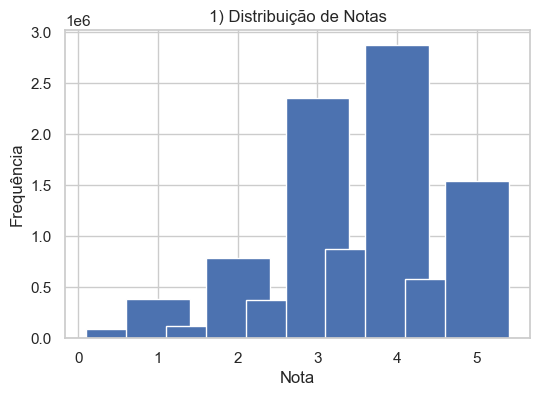


=== 2) Top 10 filmes mais avaliados ===
shape: (10, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n_ratings ‚îÇ
‚îÇ ---                             ‚îÜ ---       ‚îÇ
‚îÇ str                             ‚îÜ i64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Pulp Fiction (1994)             ‚îÜ 34864     ‚îÇ
‚îÇ Forrest Gump (1994)             ‚îÜ 34457     ‚îÇ
‚îÇ Silence of the Lambs, The (199‚Ä¶ ‚îÜ 33668     ‚îÇ
‚îÇ Jurassic Park (1993)            ‚îÜ 32631     ‚îÇ
‚îÇ Shawshank Redemption, The (199‚Ä¶ ‚îÜ 31126     ‚îÇ
‚îÇ Braveheart (1995)               ‚îÜ 29154     ‚îÇ
‚îÇ Fugitive, The (1993)            ‚îÜ 28951     ‚îÇ
‚îÇ Terminator 2: Judgment Day (19‚Ä¶ ‚îÜ 28948     ‚îÇ
‚îÇ Star Wars: Episode IV - A New ‚Ä¶ ‚îÜ 28566     ‚îÇ
‚îÇ 

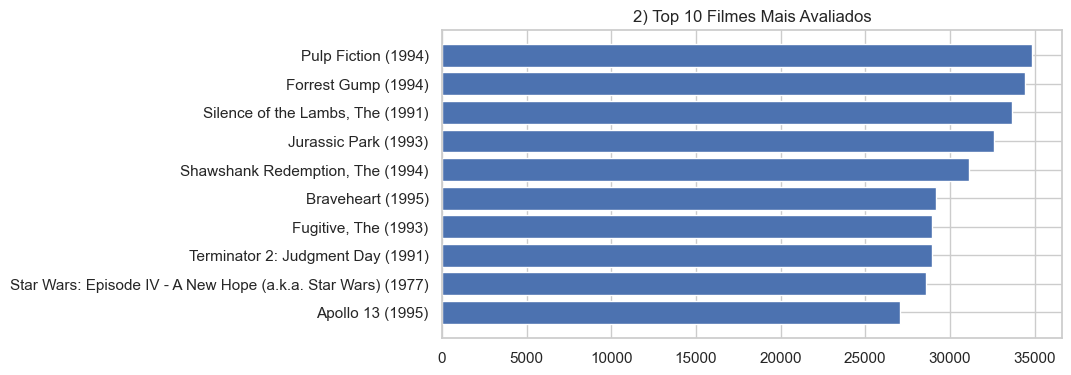


=== 3) Top 10 filmes com melhor m√©dia (‚â•100 avalia√ß√µes) ===
shape: (10, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n_ratings ‚îÜ avg_rating ‚îÇ
‚îÇ ---                             ‚îÜ ---       ‚îÜ ---        ‚îÇ
‚îÇ str                             ‚îÜ i64       ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Shawshank Redemption, The (199‚Ä¶ ‚îÜ 31126     ‚îÜ 4.457238   ‚îÇ
‚îÇ Godfather, The (1972)           ‚îÜ 19814     ‚îÜ 4.415085   ‚îÇ
‚îÇ Usual Suspects, The (1995)      ‚îÜ 24037     ‚îÜ 4.367142   ‚îÇ
‚îÇ Schindler's List (1993)         ‚îÜ 25777     ‚îÜ 4.363483   ‚îÇ
‚îÇ Sunset Blvd. (a.k.a. Sunset Bo‚Ä¶ ‚îÜ 3255      ‚îÜ 4.321966   ‚îÇ
‚

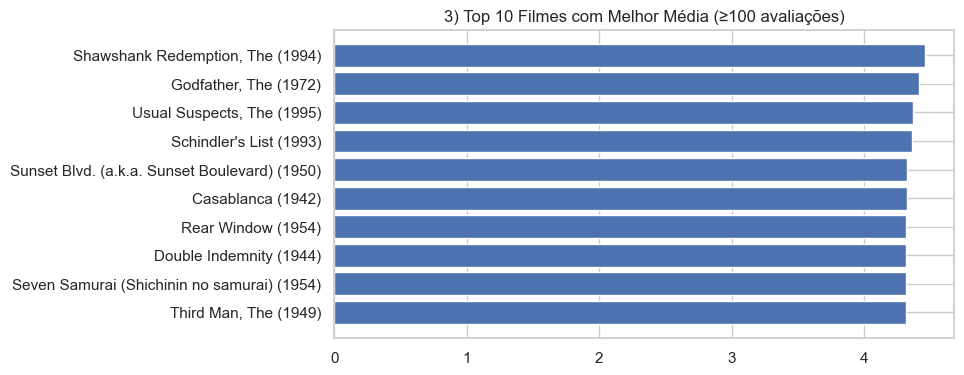


=== 4) Popularidade por g√™nero ===
shape: (19, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ genre     ‚îÜ n_movies ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÇ
‚îÇ str       ‚îÜ i64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Drama     ‚îÜ 5339     ‚îÇ
‚îÇ Comedy    ‚îÜ 3703     ‚îÇ
‚îÇ Thriller  ‚îÜ 1706     ‚îÇ
‚îÇ Romance   ‚îÜ 1685     ‚îÇ
‚îÇ Action    ‚îÜ 1473     ‚îÇ
‚îÇ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ Musical   ‚îÜ 436      ‚îÇ
‚îÇ Animation ‚îÜ 286      ‚îÇ
‚îÇ Western   ‚îÜ 275      ‚îÇ
‚îÇ Film-Noir ‚îÜ 148      ‚îÇ
‚îÇ IMAX      ‚îÜ 29       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


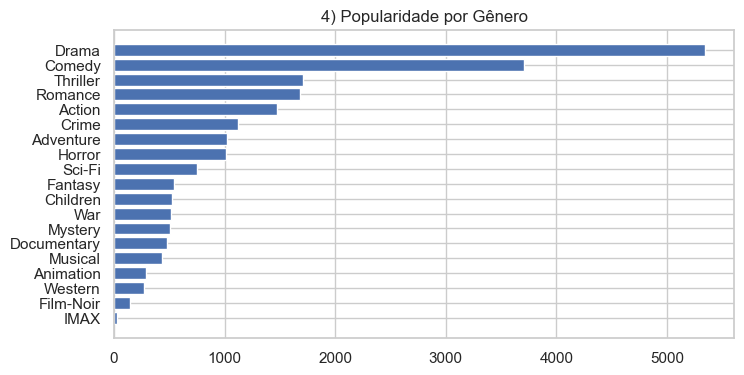


=== 5) Atividade de avalia√ß√µes ao longo do tempo ===
shape: (12, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ month                       ‚îÜ n_ratings ‚îÇ
‚îÇ ---                         ‚îÜ ---       ‚îÇ
‚îÇ datetime[Œºs, Europe/London] ‚îÜ i64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1995-01-01 00:00:00 GMT     ‚îÜ 3         ‚îÇ
‚îÇ 1996-01-01 00:00:00 GMT     ‚îÜ 21        ‚îÇ
‚îÇ 1996-02-01 00:00:00 GMT     ‚îÜ 336       ‚îÇ
‚îÇ 1996-03-01 00:00:00 GMT     ‚îÜ 6573      ‚îÇ
‚îÇ 1996-04-01 00:00:00 BST     ‚îÜ 34944     ‚îÇ
‚îÇ ‚Ä¶                           ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 1996-07-01 00:00:00 BST     ‚îÜ 142567    ‚îÇ
‚îÇ 1996-08-01 00:00:00 BST     ‚îÜ 142711    ‚îÇ
‚îÇ 1996-09-01 00:00:00 BST     ‚îÜ 97533     ‚îÇ
‚îÇ 1996-10-01 00:00:00 BST     ‚îÜ 125259    ‚îÇ
‚îÇ 1996-11-01

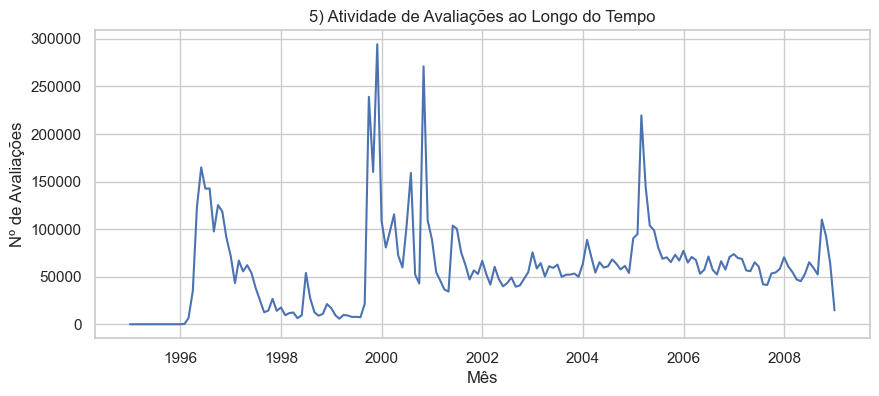


=== 6) Ciclo de vida por ano de lan√ßamento ===
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ year_guess ‚îÜ n_ratings ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÇ
‚îÇ i32        ‚îÜ i64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1915       ‚îÜ 203       ‚îÇ
‚îÇ 1916       ‚îÜ 101       ‚îÇ
‚îÇ 1917       ‚îÜ 36        ‚îÇ
‚îÇ 1918       ‚îÜ 82        ‚îÇ
‚îÇ 1919       ‚îÜ 183       ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 1930       ‚îÜ 2758      ‚îÇ
‚îÇ 1931       ‚îÜ 8483      ‚îÇ
‚îÇ 1932       ‚îÜ 3604      ‚îÇ
‚îÇ 1933       ‚îÜ 8527      ‚îÇ
‚îÇ 1934       ‚îÜ 6600      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


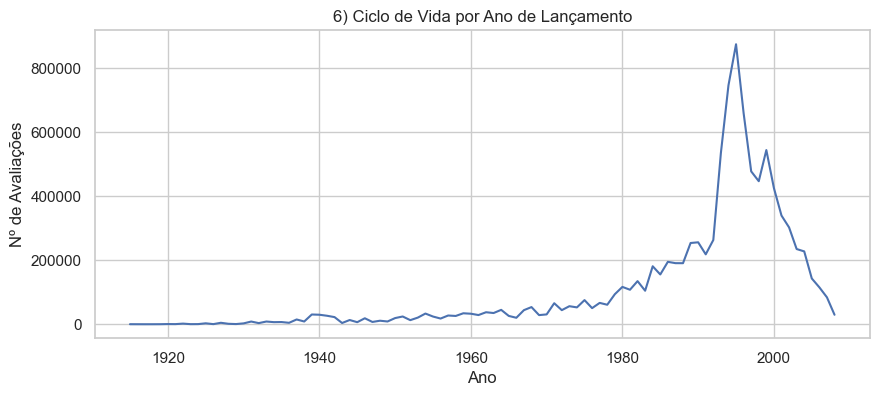


=== 7) Distribui√ß√£o de avalia√ß√µes por filme (long tail) ===
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ movieId ‚îÜ n_ratings ‚îÇ
‚îÇ ---     ‚îÜ ---       ‚îÇ
‚îÇ i64     ‚îÜ i64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 296     ‚îÜ 34864     ‚îÇ
‚îÇ 356     ‚îÜ 34457     ‚îÇ
‚îÇ 593     ‚îÜ 33668     ‚îÇ
‚îÇ 480     ‚îÜ 32631     ‚îÇ
‚îÇ 318     ‚îÜ 31126     ‚îÇ
‚îÇ ‚Ä¶       ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 380     ‚îÜ 25381     ‚îÇ
‚îÇ 1210    ‚îÜ 25098     ‚îÇ
‚îÇ 32      ‚îÜ 24397     ‚îÇ
‚îÇ 50      ‚îÜ 24037     ‚îÇ
‚îÇ 608     ‚îÜ 23794     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


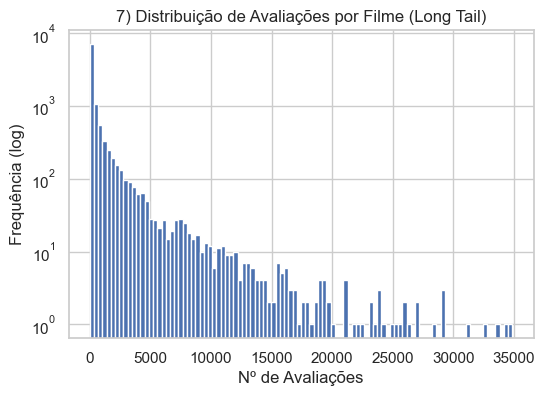


=== 8) Tags mais frequentes ===
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ tag                   ‚îÜ freq ‚îÇ
‚îÇ ---                   ‚îÜ ---  ‚îÇ
‚îÇ str                   ‚îÜ i64  ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ classic               ‚îÜ 718  ‚îÇ
‚îÇ tumey's dvds          ‚îÜ 641  ‚îÇ
‚îÇ based on a book       ‚îÜ 555  ‚îÇ
‚îÇ r                     ‚îÜ 518  ‚îÇ
‚îÇ less than 300 ratings ‚îÜ 505  ‚îÇ
‚îÇ ‚Ä¶                     ‚îÜ ‚Ä¶    ‚îÇ
‚îÇ drama                 ‚îÜ 349  ‚îÇ
‚îÇ movie to see          ‚îÜ 345  ‚îÇ
‚îÇ disney                ‚îÜ 335  ‚îÇ
‚îÇ imdb top 250          ‚îÜ 318  ‚îÇ
‚îÇ world war ii          ‚îÜ 315  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


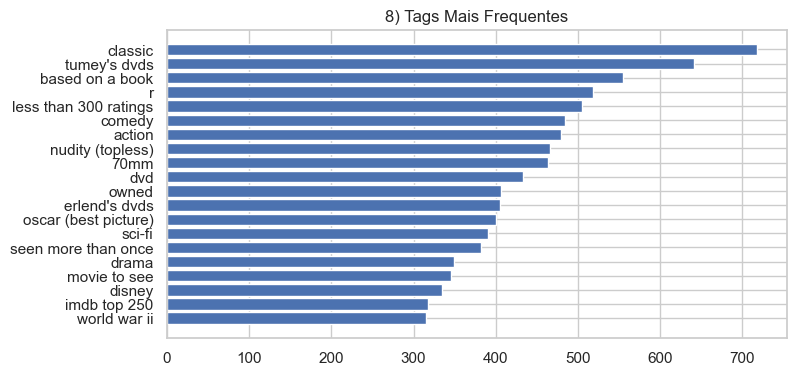


=== 9) Co-ocorr√™ncia de g√™neros ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ g1        ‚îÜ g2       ‚îÜ n    ‚îÇ
‚îÇ ---       ‚îÜ ---      ‚îÜ ---  ‚îÇ
‚îÇ str       ‚îÜ str      ‚îÜ i64  ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Comedy    ‚îÜ Drama    ‚îÜ 1081 ‚îÇ
‚îÇ Drama     ‚îÜ Romance  ‚îÜ 1006 ‚îÇ
‚îÇ Comedy    ‚îÜ Romance  ‚îÜ 847  ‚îÇ
‚îÇ Drama     ‚îÜ Thriller ‚îÜ 768  ‚îÇ
‚îÇ Crime     ‚îÜ Drama    ‚îÜ 638  ‚îÇ
‚îÇ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶    ‚îÇ
‚îÇ Adventure ‚îÜ Comedy   ‚îÜ 282  ‚îÇ
‚îÇ Mystery   ‚îÜ Thriller ‚îÜ 277  ‚îÇ
‚îÇ Action    ‚îÜ Sci-Fi   ‚îÜ 270  ‚îÇ
‚îÇ Children  ‚îÜ Comedy   ‚îÜ 256  ‚îÇ
‚îÇ Drama     ‚îÜ Mystery  ‚îÜ 242  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


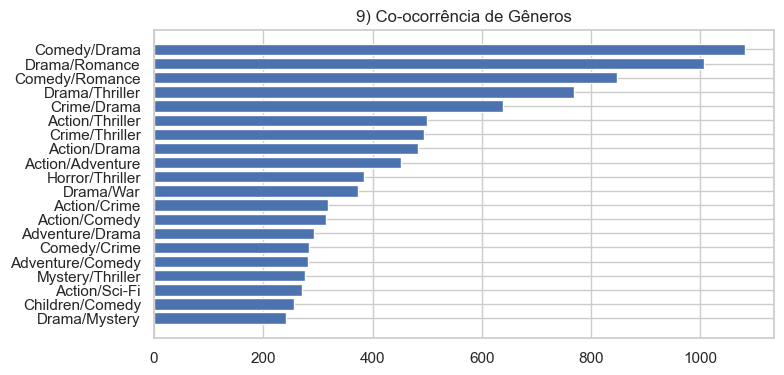


=== 10) M√©dia global ===
shape: (1, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ gmean    ‚îÇ
‚îÇ ---      ‚îÇ
‚îÇ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 3.512422 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


In [66]:
import os
import polars as pl
import matplotlib.pyplot as plt

# Fun√ß√£o auxiliar
def q(sql: str) -> pl.DataFrame:
    return pl.from_arrow(con.execute(sql).arrow())

# Diret√≥rio de sa√≠da
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# 1) Distribui√ß√£o de notas
stat1 = q("""
    SELECT rating::DOUBLE AS rating, COUNT(*) AS freq
    FROM ratings
    GROUP BY rating
    ORDER BY rating
""")
print("=== 1) Distribui√ß√£o de notas ===")
print(stat1)
plt.figure(figsize=(6,4))
plt.bar(stat1["rating"], stat1["freq"])
plt.title("1) Distribui√ß√£o de Notas")
plt.xlabel("Nota")
plt.ylabel("Frequ√™ncia")
plt.savefig(os.path.join(output_dir, "01_distribuicao_notas.png"))
plt.show()

# 2) Top 10 filmes mais avaliados
stat2 = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    ORDER BY n_ratings DESC
    LIMIT 10
""")
print("\n=== 2) Top 10 filmes mais avaliados ===")
print(stat2)
plt.figure(figsize=(8,4))
plt.barh(stat2["title"], stat2["n_ratings"])
plt.title("2) Top 10 Filmes Mais Avaliados")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "02_top10_filmes.png"))
plt.show()

# 3) Top 10 filmes com melhor m√©dia (‚â•100 avalia√ß√µes)
stat3 = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings, AVG(r.rating) AS avg_rating
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 100
    ORDER BY avg_rating DESC
    LIMIT 10
""")
print("\n=== 3) Top 10 filmes com melhor m√©dia (‚â•100 avalia√ß√µes) ===")
print(stat3)
plt.figure(figsize=(8,4))
plt.barh(stat3["title"], stat3["avg_rating"])
plt.title("3) Top 10 Filmes com Melhor M√©dia (‚â•100 avalia√ß√µes)")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "03_top10_melhor_media.png"))
plt.show()

# 4) Popularidade por g√™nero
stat4 = q("""
    WITH exploded AS (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    )
    SELECT genre, COUNT(*) AS n_movies
    FROM exploded
    GROUP BY genre
    ORDER BY n_movies DESC
""")
print("\n=== 4) Popularidade por g√™nero ===")
print(stat4)
plt.figure(figsize=(8,4))
plt.barh(stat4["genre"], stat4["n_movies"])
plt.title("4) Popularidade por G√™nero")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "04_popularidade_genero.png"))
plt.show()

# 5) Atividade de avalia√ß√µes ao longo do tempo (mensal)
stat5 = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY month
    ORDER BY month
""")
print("\n=== 5) Atividade de avalia√ß√µes ao longo do tempo ===")
print(stat5.head(12))
plt.figure(figsize=(10,4))
plt.plot(stat5["month"], stat5["n_ratings"])
plt.title("5) Atividade de Avalia√ß√µes ao Longo do Tempo")
plt.xlabel("M√™s")
plt.ylabel("N¬∫ de Avalia√ß√µes")
plt.savefig(os.path.join(output_dir, "05_avaliacoes_tempo.png"))
plt.show()

# 6) Ciclo de vida por ano de lan√ßamento
stat6 = q("""
    SELECT CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) AS year_guess,
           COUNT(r.rating) AS n_ratings
    FROM movies m
    LEFT JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(%)'
      AND TRY_CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) IS NOT NULL
    GROUP BY year_guess
    ORDER BY year_guess
""")
print("\n=== 6) Ciclo de vida por ano de lan√ßamento ===")
print(stat6.head(20))
plt.figure(figsize=(10,4))
plt.plot(stat6["year_guess"], stat6["n_ratings"])
plt.title("6) Ciclo de Vida por Ano de Lan√ßamento")
plt.xlabel("Ano")
plt.ylabel("N¬∫ de Avalia√ß√µes")
plt.savefig(os.path.join(output_dir, "06_ciclo_vida.png"))
plt.show()

# 7) Atividade por filme (long tail)
stat7 = q("""
    SELECT movieId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY movieId
    ORDER BY n_ratings DESC
""")
print("\n=== 7) Distribui√ß√£o de avalia√ß√µes por filme (long tail) ===")
print(stat7.head(20))
plt.figure(figsize=(6,4))
plt.hist(stat7["n_ratings"], bins=100, log=True)
plt.title("7) Distribui√ß√£o de Avalia√ß√µes por Filme (Long Tail)")
plt.xlabel("N¬∫ de Avalia√ß√µes")
plt.ylabel("Frequ√™ncia (log)")
plt.savefig(os.path.join(output_dir, "07_long_tail.png"))
plt.show()

# 8) Tags mais frequentes
stat8 = q("""
    SELECT LOWER(TRIM(tag)) AS tag, COUNT(*) AS freq
    FROM tags
    WHERE tag IS NOT NULL AND TRIM(tag) <> ''
    GROUP BY LOWER(TRIM(tag))
    ORDER BY freq DESC
    LIMIT 20
""")
print("\n=== 8) Tags mais frequentes ===")
print(stat8)
plt.figure(figsize=(8,4))
plt.barh(stat8["tag"], stat8["freq"])
plt.title("8) Tags Mais Frequentes")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "08_tags_frequentes.png"))
plt.show()

# 9) Co-ocorr√™ncia de g√™neros
stat9 = q("""
    WITH exploded AS (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    ),
    pairs AS (
        SELECT a.movieId, LEAST(a.genre,b.genre) AS g1, GREATEST(a.genre,b.genre) AS g2
        FROM exploded a
        JOIN exploded b ON a.movieId = b.movieId AND a.genre < b.genre
    )
    SELECT g1, g2, COUNT(*) AS n
    FROM pairs
    GROUP BY g1, g2
    ORDER BY n DESC
    LIMIT 20
""")
print("\n=== 9) Co-ocorr√™ncia de g√™neros ===")
print(stat9)
plt.figure(figsize=(8,4))
plt.barh([f"{g1}/{g2}" for g1,g2 in zip(stat9["g1"], stat9["g2"])], stat9["n"])
plt.title("9) Co-ocorr√™ncia de G√™neros")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "09_coocorrencia_generos.png"))
plt.show()

# 10) M√©dia global
stat10 = q("SELECT AVG(rating) AS gmean FROM ratings")
print("\n=== 10) M√©dia global ===")
print(stat10)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

=== 11) Distribui√ß√£o de n¬∫ de avalia√ß√µes por usu√°rio ===
shape: (9, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ userId       ‚îÜ n_ratings ‚îÇ
‚îÇ ---        ‚îÜ ---          ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ f64          ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 69878.0      ‚îÜ 69878.0   ‚îÇ
‚îÇ null_count ‚îÜ 0.0          ‚îÜ 0.0       ‚îÇ
‚îÇ mean       ‚îÜ 35782.217393 ‚îÜ 143.10733 ‚îÇ
‚îÇ std        ‚îÜ 20613.909098 ‚îÜ 216.71258 ‚îÇ
‚îÇ min        ‚îÜ 1.0          ‚îÜ 20.0      ‚îÇ
‚îÇ 25%        ‚îÜ 17943.0      ‚îÜ 35.0      ‚îÇ
‚îÇ 50%        ‚îÜ 35799.0      ‚îÜ 69.0      ‚îÇ
‚îÇ 75%        ‚îÜ 53620.0      ‚îÜ 156.0     ‚îÇ
‚îÇ max        ‚îÜ 71567.0      ‚îÜ 7359.0    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

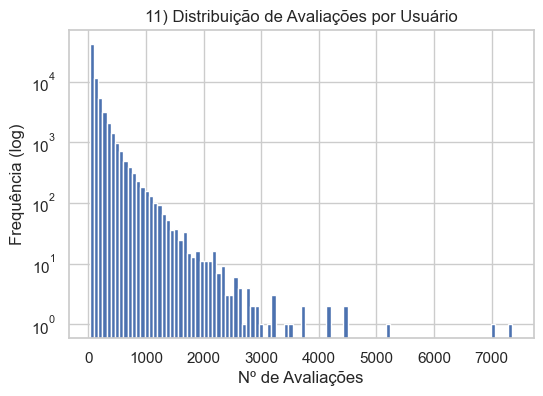


=== 12) Distribui√ß√£o da m√©dia de notas por usu√°rio ===
shape: (9, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ userId       ‚îÜ avg_rating ‚îÇ
‚îÇ ---        ‚îÜ ---          ‚îÜ ---        ‚îÇ
‚îÇ str        ‚îÜ f64          ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 69878.0      ‚îÜ 69878.0    ‚îÇ
‚îÇ null_count ‚îÜ 0.0          ‚îÜ 0.0        ‚îÇ
‚îÇ mean       ‚îÜ 35782.217393 ‚îÜ 3.613641   ‚îÇ
‚îÇ std        ‚îÜ 20613.909098 ‚îÜ 0.428244   ‚îÇ
‚îÇ min        ‚îÜ 1.0          ‚îÜ 0.5        ‚îÇ
‚îÇ 25%        ‚îÜ 17943.0      ‚îÜ 3.36       ‚îÇ
‚îÇ 50%        ‚îÜ 35799.0      ‚îÜ 3.634615   ‚îÇ
‚îÇ 75%        ‚îÜ 53620.0      ‚îÜ 3.9        ‚îÇ
‚îÇ max        ‚îÜ 71567.0      ‚îÜ 5.0        ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

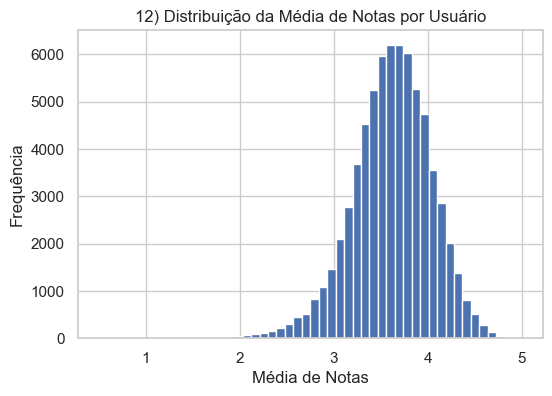


=== 13) Top 20 usu√°rios mais ativos ===
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ userId ‚îÜ n_ratings ‚îÇ
‚îÇ ---    ‚îÜ ---       ‚îÇ
‚îÇ i64    ‚îÜ i64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 59269  ‚îÜ 7359      ‚îÇ
‚îÇ 67385  ‚îÜ 7047      ‚îÇ
‚îÇ 14463  ‚îÜ 5169      ‚îÇ
‚îÇ 68259  ‚îÜ 4483      ‚îÇ
‚îÇ 27468  ‚îÜ 4449      ‚îÇ
‚îÇ ‚Ä¶      ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 30723  ‚îÜ 3027      ‚îÇ
‚îÇ 30687  ‚îÜ 2909      ‚îÇ
‚îÇ 31327  ‚îÜ 2886      ‚îÇ
‚îÇ 30500  ‚îÜ 2827      ‚îÇ
‚îÇ 47046  ‚îÜ 2812      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


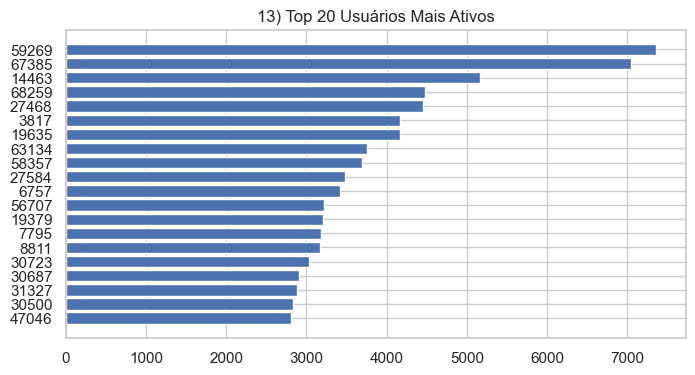


=== 14) M√©dia de notas por g√™nero ===
shape: (19, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ genre       ‚îÜ avg_rating ‚îÇ
‚îÇ ---         ‚îÜ ---        ‚îÇ
‚îÇ str         ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Film-Noir   ‚îÜ 4.012151   ‚îÇ
‚îÇ Documentary ‚îÜ 3.783459   ‚îÇ
‚îÇ War         ‚îÜ 3.780173   ‚îÇ
‚îÇ IMAX        ‚îÜ 3.764537   ‚îÇ
‚îÇ Mystery     ‚îÜ 3.677631   ‚îÇ
‚îÇ ‚Ä¶           ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ Comedy      ‚îÜ 3.436946   ‚îÇ
‚îÇ Action      ‚îÜ 3.421331   ‚îÇ
‚îÇ Children    ‚îÜ 3.418474   ‚îÇ
‚îÇ Sci-Fi      ‚îÜ 3.396193   ‚îÇ
‚îÇ Horror      ‚îÜ 3.269243   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


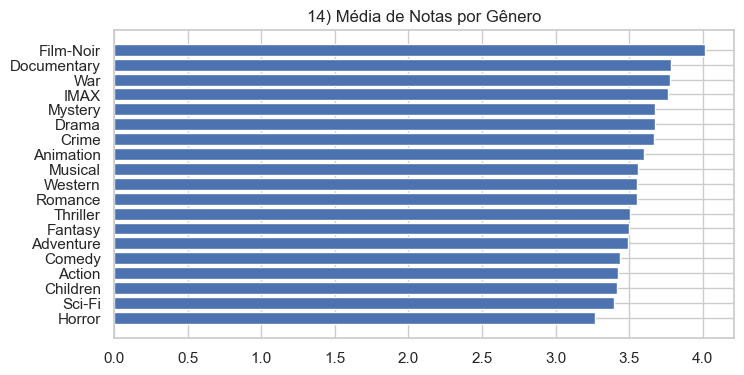


=== 15) Usu√°rios √∫nicos por m√™s ===
shape: (12, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ month                       ‚îÜ n_users ‚îÇ
‚îÇ ---                         ‚îÜ ---     ‚îÇ
‚îÇ datetime[Œºs, Europe/London] ‚îÜ i64     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1995-01-01 00:00:00 GMT     ‚îÜ 1       ‚îÇ
‚îÇ 1996-01-01 00:00:00 GMT     ‚îÜ 4       ‚îÇ
‚îÇ 1996-02-01 00:00:00 GMT     ‚îÜ 17      ‚îÇ
‚îÇ 1996-03-01 00:00:00 GMT     ‚îÜ 162     ‚îÇ
‚îÇ 1996-04-01 00:00:00 BST     ‚îÜ 838     ‚îÇ
‚îÇ ‚Ä¶                           ‚îÜ ‚Ä¶       ‚îÇ
‚îÇ 1996-07-01 00:00:00 BST     ‚îÜ 2806    ‚îÇ
‚îÇ 1996-08-01 00:00:00 BST     ‚îÜ 2784    ‚îÇ
‚îÇ 1996-09-01 00:00:00 BST     ‚îÜ 2119    ‚îÇ
‚îÇ 1996-10-01 00:00:00 BST     ‚îÜ 2591    ‚îÇ
‚îÇ 1996-11-01 00:00:00 GMT     ‚îÜ 2359    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

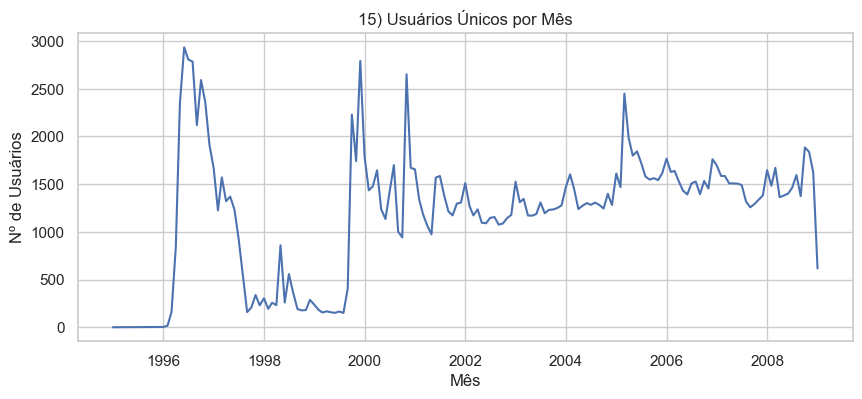

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== 16) Filmes distintos avaliados por m√™s ===
shape: (12, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ month                       ‚îÜ n_movies ‚îÇ
‚îÇ ---                         ‚îÜ ---      ‚îÇ
‚îÇ datetime[Œºs, Europe/London] ‚îÜ i64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1995-01-01 00:00:00 GMT     ‚îÜ 3        ‚îÇ
‚îÇ 1996-01-01 00:00:00 GMT     ‚îÜ 15       ‚îÇ
‚îÇ 1996-02-01 00:00:00 GMT     ‚îÜ 101      ‚îÇ
‚îÇ 1996-03-01 00:00:00 GMT     ‚îÜ 447      ‚îÇ
‚îÇ 1996-04-01 00:00:00 BST     ‚îÜ 416      ‚îÇ
‚îÇ ‚Ä¶                           ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ 1996-07-01 00:00:00 BST     ‚îÜ 662      ‚îÇ
‚îÇ 1996-08-01 00:00:00 BST     ‚îÜ 821      ‚îÇ
‚îÇ 1996-09-01 00:00:00 BST     ‚îÜ 818      ‚îÇ
‚îÇ 1996-10-01 00:00:00 BST     ‚îÜ 1178     ‚îÇ
‚îÇ 1996-11-01 00:00:00 GMT     ‚îÜ 1224

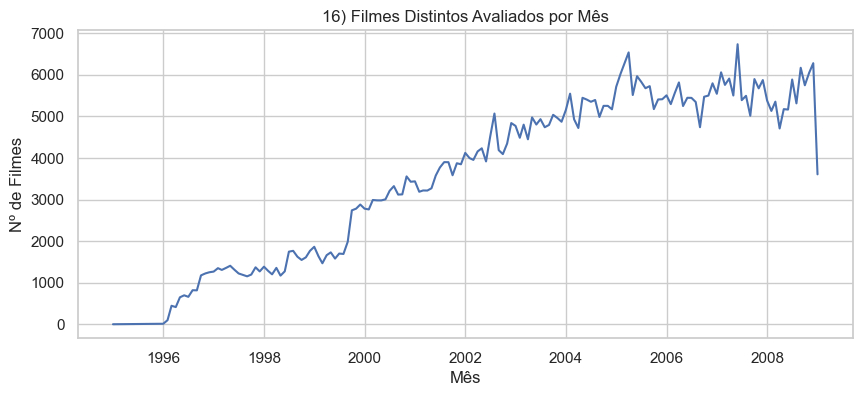


=== 17) Rela√ß√£o n¬∫ de avalia√ß√µes x m√©dia do filme (top 20) ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n_ratings ‚îÜ avg_rating ‚îÇ
‚îÇ ---                             ‚îÜ ---       ‚îÜ ---        ‚îÇ
‚îÇ str                             ‚îÜ i64       ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Pulp Fiction (1994)             ‚îÜ 34864     ‚îÜ 4.157426   ‚îÇ
‚îÇ Forrest Gump (1994)             ‚îÜ 34457     ‚îÜ 4.013582   ‚îÇ
‚îÇ Silence of the Lambs, The (199‚Ä¶ ‚îÜ 33668     ‚îÜ 4.2042     ‚îÇ
‚îÇ Jurassic Park (1993)            ‚îÜ 32631     ‚îÜ 3.661564   ‚îÇ
‚îÇ Shawshank Redemption, The (199‚Ä¶ ‚îÜ 31126     ‚îÜ 4.457238   ‚

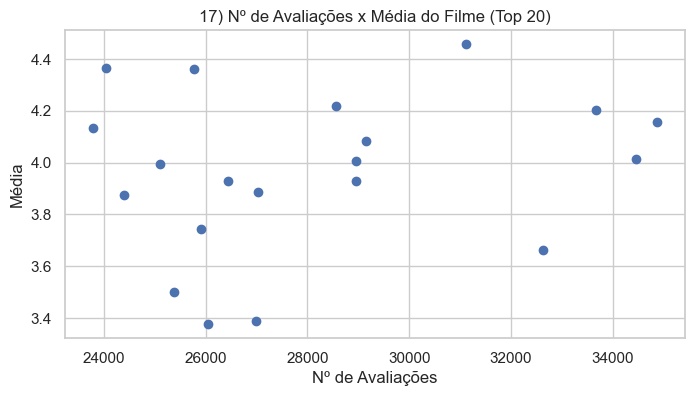


=== 18) Distribui√ß√£o de avalia√ß√µes por hora ===
shape: (24, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ hour ‚îÜ n_ratings ‚îÇ
‚îÇ ---  ‚îÜ ---       ‚îÇ
‚îÇ i64  ‚îÜ i64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0    ‚îÜ 474841    ‚îÇ
‚îÇ 1    ‚îÜ 451974    ‚îÇ
‚îÇ 2    ‚îÜ 428121    ‚îÇ
‚îÇ 3    ‚îÜ 433471    ‚îÇ
‚îÇ 4    ‚îÜ 416928    ‚îÇ
‚îÇ ‚Ä¶    ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 19   ‚îÜ 571961    ‚îÇ
‚îÇ 20   ‚îÜ 571946    ‚îÇ
‚îÇ 21   ‚îÜ 591953    ‚îÇ
‚îÇ 22   ‚îÜ 567737    ‚îÇ
‚îÇ 23   ‚îÜ 507400    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


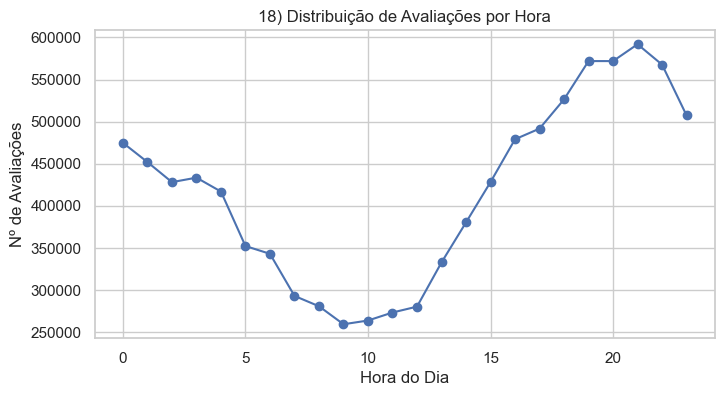


=== 19) Distribui√ß√£o de avalia√ß√µes por dia da semana ===
shape: (7, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ dow ‚îÜ n_ratings ‚îÇ
‚îÇ --- ‚îÜ ---       ‚îÇ
‚îÇ i64 ‚îÜ i64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0   ‚îÜ 1363969   ‚îÇ
‚îÇ 1   ‚îÜ 1561492   ‚îÇ
‚îÇ 2   ‚îÜ 1596147   ‚îÇ
‚îÇ 3   ‚îÜ 1479151   ‚îÇ
‚îÇ 4   ‚îÜ 1381722   ‚îÇ
‚îÇ 5   ‚îÜ 1366327   ‚îÇ
‚îÇ 6   ‚îÜ 1251246   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


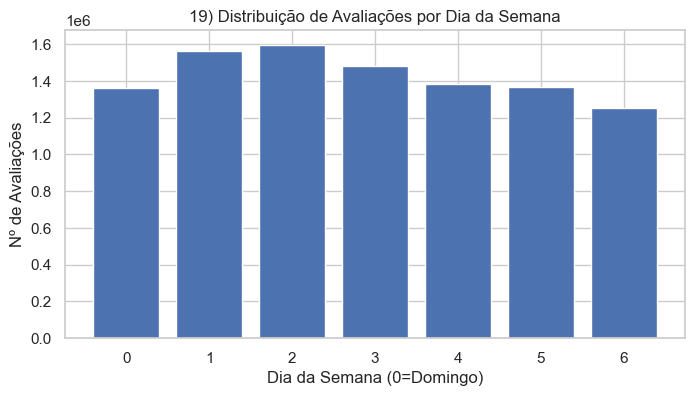


=== 20) Filmes mais polarizadores ===
shape: (15, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n     ‚îÜ std      ‚îÇ
‚îÇ ---                             ‚îÜ ---   ‚îÜ ---      ‚îÇ
‚îÇ str                             ‚îÜ i64   ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Plan 9 from Outer Space (1959)  ‚îÜ 1368  ‚îÜ 1.408317 ‚îÇ
‚îÇ Passion of the Christ, The (20‚Ä¶ ‚îÜ 1600  ‚îÜ 1.351458 ‚îÇ
‚îÇ Stupids, The (1996)             ‚îÜ 678   ‚îÜ 1.326324 ‚îÇ
‚îÇ Children of the Corn IV: The G‚Ä¶ ‚îÜ 570   ‚îÜ 1.32028  ‚îÇ
‚îÇ Texas Chainsaw Massacre, The (‚Ä¶ ‚îÜ 1587  ‚îÜ 1.297798 ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶     ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ Crash (1996)                    ‚îÜ 1

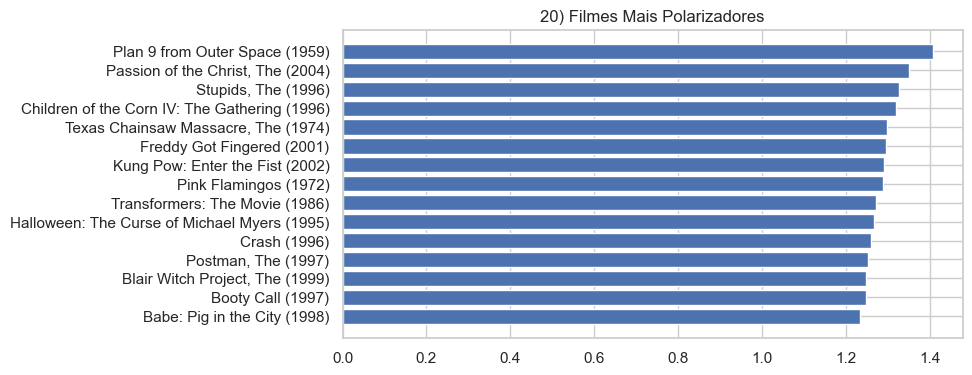

In [67]:
# 11) Distribui√ß√£o de n¬∫ de avalia√ß√µes por usu√°rio
stat11 = q("""
    SELECT userId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY userId
""")
print("=== 11) Distribui√ß√£o de n¬∫ de avalia√ß√µes por usu√°rio ===")
print(stat11.describe())
plt.figure(figsize=(6,4))
plt.hist(stat11["n_ratings"], bins=100, log=True)
plt.title("11) Distribui√ß√£o de Avalia√ß√µes por Usu√°rio")
plt.xlabel("N¬∫ de Avalia√ß√µes")
plt.ylabel("Frequ√™ncia (log)")
plt.savefig(os.path.join(output_dir, "11_avaliacoes_usuario.png"))
plt.show()

# 12) Distribui√ß√£o da m√©dia de notas por usu√°rio
stat12 = q("""
    SELECT userId, AVG(rating) AS avg_rating
    FROM ratings
    GROUP BY userId
""")
print("\n=== 12) Distribui√ß√£o da m√©dia de notas por usu√°rio ===")
print(stat12.describe())
plt.figure(figsize=(6,4))
plt.hist(stat12["avg_rating"], bins=50)
plt.title("12) Distribui√ß√£o da M√©dia de Notas por Usu√°rio")
plt.xlabel("M√©dia de Notas")
plt.ylabel("Frequ√™ncia")
plt.savefig(os.path.join(output_dir, "12_media_usuario.png"))
plt.show()

# 13) Top 20 usu√°rios mais ativos
stat13 = q("""
    SELECT userId, COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY userId
    ORDER BY n_ratings DESC
    LIMIT 20
""")
print("\n=== 13) Top 20 usu√°rios mais ativos ===")
print(stat13)
plt.figure(figsize=(8,4))
plt.barh(stat13["userId"].cast(str), stat13["n_ratings"])
plt.title("13) Top 20 Usu√°rios Mais Ativos")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "13_top20_usuarios.png"))
plt.show()

# 14) Notas por g√™nero (m√©dia)
stat14 = q("""
    WITH exploded AS (
        SELECT r.rating, UNNEST(STRING_SPLIT(m.genres, '|')) AS genre
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    )
    SELECT genre, AVG(rating) AS avg_rating
    FROM exploded
    GROUP BY genre
    ORDER BY avg_rating DESC
""")
print("\n=== 14) M√©dia de notas por g√™nero ===")
print(stat14)
plt.figure(figsize=(8,4))
plt.barh(stat14["genre"], stat14["avg_rating"])
plt.title("14) M√©dia de Notas por G√™nero")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "14_media_genero.png"))
plt.show()

# 15) Usu√°rios √∫nicos por m√™s
stat15 = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(DISTINCT userId) AS n_users
    FROM ratings
    GROUP BY month
    ORDER BY month
""")
print("\n=== 15) Usu√°rios √∫nicos por m√™s ===")
print(stat15.head(12))
plt.figure(figsize=(10,4))
plt.plot(stat15["month"], stat15["n_users"])
plt.title("15) Usu√°rios √önicos por M√™s")
plt.xlabel("M√™s")
plt.ylabel("N¬∫ de Usu√°rios")
plt.savefig(os.path.join(output_dir, "15_usuarios_mes.png"))
plt.show()

# 16) Filmes distintos avaliados por m√™s
stat16 = q("""
    SELECT DATE_TRUNC('month', TO_TIMESTAMP(timestamp)) AS month,
           COUNT(DISTINCT movieId) AS n_movies
    FROM ratings
    GROUP BY month
    ORDER BY month
""")
print("\n=== 16) Filmes distintos avaliados por m√™s ===")
print(stat16.head(12))
plt.figure(figsize=(10,4))
plt.plot(stat16["month"], stat16["n_movies"])
plt.title("16) Filmes Distintos Avaliados por M√™s")
plt.xlabel("M√™s")
plt.ylabel("N¬∫ de Filmes")
plt.savefig(os.path.join(output_dir, "16_filmes_mes.png"))
plt.show()

# 17) Rela√ß√£o n¬∫ de avalia√ß√µes x m√©dia do filme (top 20)
stat17 = q("""
    SELECT m.title, COUNT(r.rating) AS n_ratings, AVG(r.rating) AS avg_rating
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    ORDER BY n_ratings DESC
    LIMIT 20
""")
print("\n=== 17) Rela√ß√£o n¬∫ de avalia√ß√µes x m√©dia do filme (top 20) ===")
print(stat17)
plt.figure(figsize=(8,4))
plt.scatter(stat17["n_ratings"], stat17["avg_rating"])
plt.title("17) N¬∫ de Avalia√ß√µes x M√©dia do Filme (Top 20)")
plt.xlabel("N¬∫ de Avalia√ß√µes")
plt.ylabel("M√©dia")
plt.savefig(os.path.join(output_dir, "17_avaliacoes_vs_media.png"))
plt.show()

# 18) Distribui√ß√£o de avalia√ß√µes por hora
stat18 = q("""
    SELECT EXTRACT('hour' FROM TO_TIMESTAMP(timestamp)) AS hour,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY hour
    ORDER BY hour
""")
print("\n=== 18) Distribui√ß√£o de avalia√ß√µes por hora ===")
print(stat18)
plt.figure(figsize=(8,4))
plt.plot(stat18["hour"], stat18["n_ratings"], marker="o")
plt.title("18) Distribui√ß√£o de Avalia√ß√µes por Hora")
plt.xlabel("Hora do Dia")
plt.ylabel("N¬∫ de Avalia√ß√µes")
plt.savefig(os.path.join(output_dir, "18_avaliacoes_hora.png"))
plt.show()

# 19) Distribui√ß√£o de avalia√ß√µes por dia da semana
stat19 = q("""
    SELECT EXTRACT('dow' FROM TO_TIMESTAMP(timestamp)) AS dow,
           COUNT(*) AS n_ratings
    FROM ratings
    GROUP BY dow
    ORDER BY dow
""")
print("\n=== 19) Distribui√ß√£o de avalia√ß√µes por dia da semana ===")
print(stat19)
plt.figure(figsize=(8,4))
plt.bar(stat19["dow"], stat19["n_ratings"])
plt.title("19) Distribui√ß√£o de Avalia√ß√µes por Dia da Semana")
plt.xlabel("Dia da Semana (0=Domingo)")
plt.ylabel("N¬∫ de Avalia√ß√µes")
plt.savefig(os.path.join(output_dir, "19_avaliacoes_semana.png"))
plt.show()

# 20) Filmes mais polarizadores (maior desvio padr√£o)
stat20 = q("""
    SELECT m.title, COUNT(r.rating) AS n, STDDEV(r.rating) AS std
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 500
    ORDER BY std DESC
    LIMIT 15
""")
print("\n=== 20) Filmes mais polarizadores ===")
print(stat20)
plt.figure(figsize=(8,4))
plt.barh(stat20["title"], stat20["std"])
plt.title("20) Filmes Mais Polarizadores")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "20_filmes_polarizadores.png"))
plt.show()

=== 21) Filmes mais consensuais ===
shape: (15, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n    ‚îÜ std      ‚îÇ
‚îÇ ---                             ‚îÜ ---  ‚îÜ ---      ‚îÇ
‚îÇ str                             ‚îÜ i64  ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Gone Baby Gone (2007)           ‚îÜ 734  ‚îÜ 0.641226 ‚îÇ
‚îÇ Last King of Scotland, The (20‚Ä¶ ‚îÜ 1281 ‚îÜ 0.644991 ‚îÇ
‚îÇ Touching the Void (2003)        ‚îÜ 888  ‚îÜ 0.65028  ‚îÇ
‚îÇ Bank Job, The (2008)            ‚îÜ 605  ‚îÜ 0.657802 ‚îÇ
‚îÇ Murder on the Orient Express (‚Ä¶ ‚îÜ 538  ‚îÜ 0.664082 ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶    ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ Good bye, Lenin! (2003)         ‚îÜ 1662 ‚îÜ 0.672287 ‚îÇ

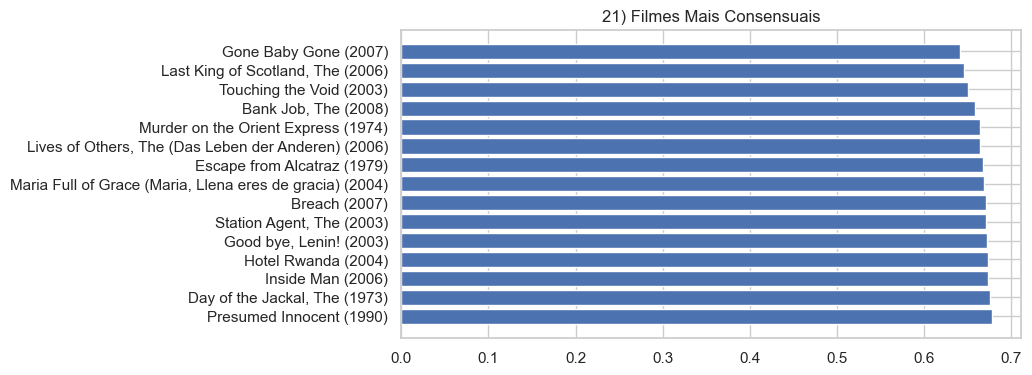


=== 22) N¬∫ de tags por usu√°rio ===
shape: (9, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ userId       ‚îÜ n_tags    ‚îÇ
‚îÇ ---        ‚îÜ ---          ‚îÜ ---       ‚îÇ
‚îÇ str        ‚îÜ f64          ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 4009.0       ‚îÜ 4009.0    ‚îÇ
‚îÇ null_count ‚îÜ 0.0          ‚îÜ 0.0       ‚îÇ
‚îÇ mean       ‚îÜ 35830.423298 ‚îÜ 23.841357 ‚îÇ
‚îÇ std        ‚îÜ 21481.275621 ‚îÜ 179.68054 ‚îÇ
‚îÇ min        ‚îÜ 15.0         ‚îÜ 1.0       ‚îÇ
‚îÇ 25%        ‚îÜ 17239.0      ‚îÜ 1.0       ‚îÇ
‚îÇ 50%        ‚îÜ 35438.0      ‚îÜ 2.0       ‚îÇ
‚îÇ 75%        ‚îÜ 54980.0      ‚îÜ 7.0       ‚îÇ
‚îÇ max        ‚îÜ 71556.0      ‚îÜ 6012.0    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚

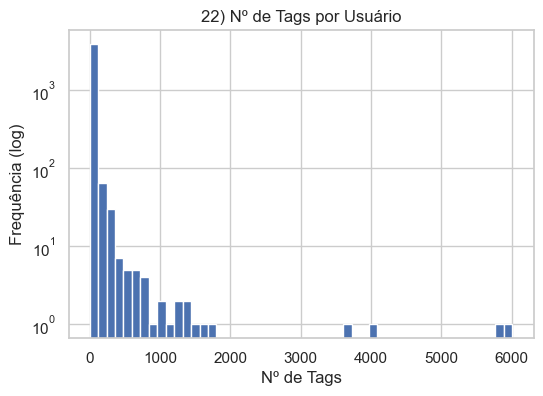

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== 23) Tags mais associadas a notas altas ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ tag                 ‚îÜ avg_rating ‚îÜ n   ‚îÇ
‚îÇ ---                 ‚îÜ ---        ‚îÜ --- ‚îÇ
‚îÇ str                 ‚îÜ f64        ‚îÜ i64 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ need to own         ‚îÜ 4.571429   ‚îÜ 91  ‚îÇ
‚îÇ studio ghibli       ‚îÜ 4.526786   ‚îÜ 56  ‚îÇ
‚îÇ classic             ‚îÜ 4.49       ‚îÜ 50  ‚îÇ
‚îÇ classic             ‚îÜ 4.43674    ‚îÜ 411 ‚îÇ
‚îÇ hilarious           ‚îÜ 4.376712   ‚îÜ 73  ‚îÇ
‚îÇ ‚Ä¶                   ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶   ‚îÇ
‚îÇ seen more than once ‚îÜ 4.195652   ‚îÜ 230 ‚îÇ
‚îÇ drama               ‚îÜ 4.195652   ‚îÜ 69  ‚îÇ
‚îÇ comedy              ‚îÜ 4.193878   ‚îÜ 147 ‚îÇ
‚îÇ surreal             ‚îÜ 4.189815   ‚îÜ 108 ‚îÇ
‚îÇ adventure 

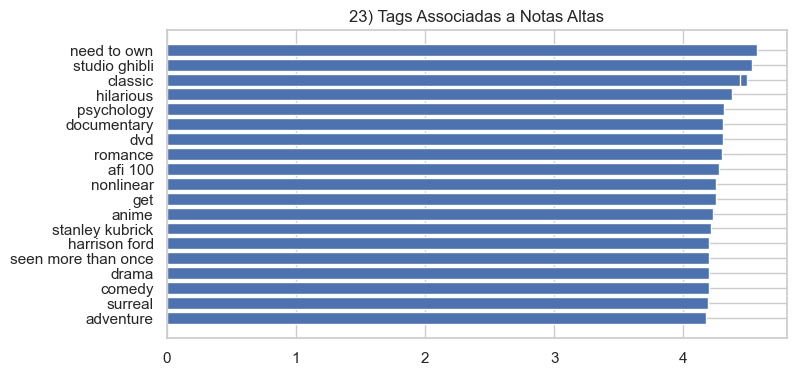


=== 24) Tags mais associadas a notas baixas ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ tag               ‚îÜ avg_rating ‚îÜ n   ‚îÇ
‚îÇ ---               ‚îÜ ---        ‚îÜ --- ‚îÇ
‚îÇ str               ‚îÜ f64        ‚îÜ i64 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ boring            ‚îÜ 1.588235   ‚îÜ 119 ‚îÇ
‚îÇ stupid            ‚îÜ 1.675926   ‚îÜ 54  ‚îÇ
‚îÇ overrated         ‚îÜ 2.483871   ‚îÜ 124 ‚îÇ
‚îÇ violent           ‚îÜ 2.611111   ‚îÜ 54  ‚îÇ
‚îÇ afternoon section ‚îÜ 2.676471   ‚îÜ 51  ‚îÇ
‚îÇ ‚Ä¶                 ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶   ‚îÇ
‚îÇ nudity (topless)  ‚îÜ 3.003268   ‚îÜ 153 ‚îÇ
‚îÇ cynical           ‚îÜ 3.029412   ‚îÜ 51  ‚îÇ
‚îÇ stylized          ‚îÜ 3.05       ‚îÜ 130 ‚îÇ
‚îÇ atmospheric       ‚îÜ 3.058065   ‚îÜ 155 ‚îÇ
‚îÇ ummarti2006       ‚îÜ 3.067797   ‚îÜ 59  ‚îÇ
‚î

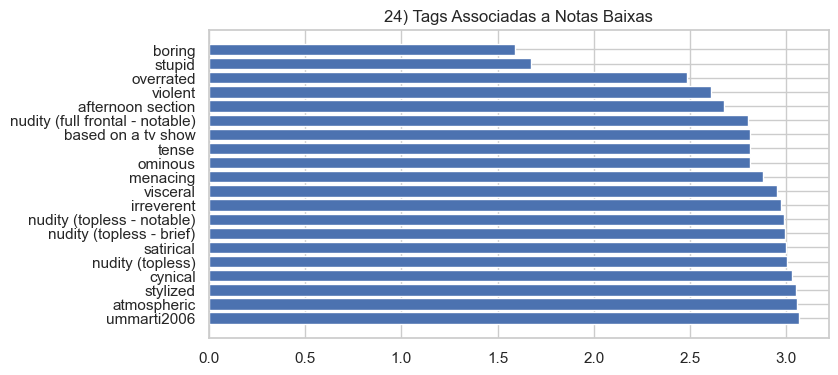

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== 25) Evolu√ß√£o da nota m√©dia por g√™nero (amostra) ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ year                        ‚îÜ genre     ‚îÜ avg_rating ‚îÇ
‚îÇ ---                         ‚îÜ ---       ‚îÜ ---        ‚îÇ
‚îÇ datetime[Œºs, Europe/London] ‚îÜ str       ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1995-01-01 00:00:00 GMT     ‚îÜ Action    ‚îÜ 3.0        ‚îÇ
‚îÇ 1995-01-01 00:00:00 GMT     ‚îÜ Comedy    ‚îÜ 3.0        ‚îÇ
‚îÇ 1995-01-01 00:00:00 GMT     ‚îÜ Crime     ‚îÜ 4.0        ‚îÇ
‚îÇ 1995-01-01 00:00:00 GMT     ‚îÜ Drama     ‚îÜ 3.0        ‚îÇ
‚îÇ 1995-01-01 00:00:00 GMT     ‚îÜ Horror    ‚îÜ 5.0        ‚îÇ
‚îÇ ‚Ä¶                           ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶        

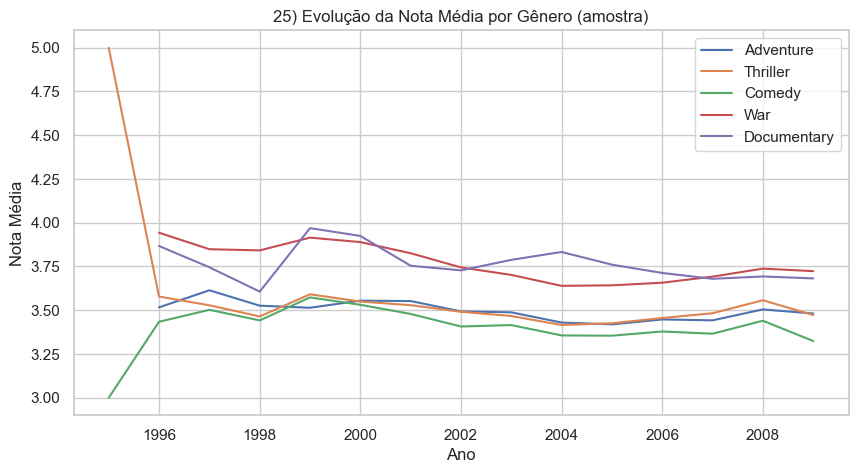


=== 26) Cl√°ssicos antigos mais bem avaliados ===
shape: (15, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ avg_rating ‚îÜ n     ‚îÇ
‚îÇ ---                             ‚îÜ ---        ‚îÜ ---   ‚îÇ
‚îÇ str                             ‚îÜ f64        ‚îÜ i64   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Sunset Blvd. (a.k.a. Sunset Bo‚Ä¶ ‚îÜ 4.321966   ‚îÜ 3255  ‚îÇ
‚îÇ Casablanca (1942)               ‚îÜ 4.319741   ‚îÜ 12507 ‚îÇ
‚îÇ Rear Window (1954)              ‚îÜ 4.316544   ‚îÜ 8825  ‚îÇ
‚îÇ Double Indemnity (1944)         ‚îÜ 4.315439   ‚îÜ 2403  ‚îÇ
‚îÇ Seven Samurai (Shichinin no sa‚Ä¶ ‚îÜ 4.314119   ‚îÜ 5751  ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶     ‚îÇ
‚

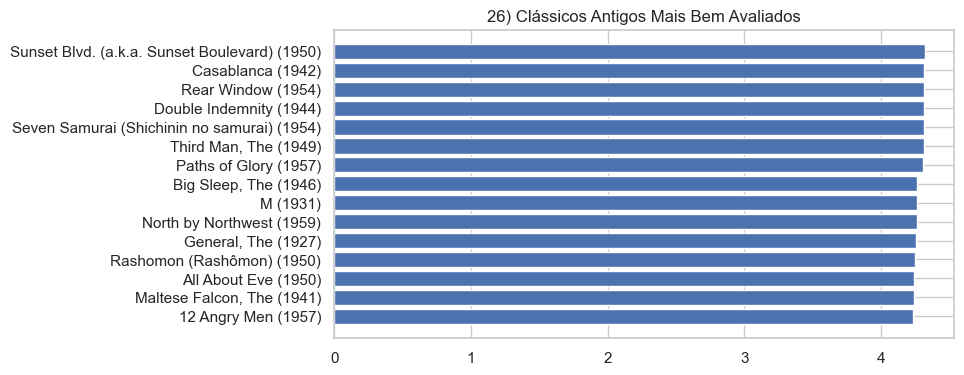


=== 27) Filmes recentes mais bem avaliados ===
shape: (15, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ avg_rating ‚îÜ n     ‚îÇ
‚îÇ ---                             ‚îÜ ---        ‚îÜ ---   ‚îÇ
‚îÇ str                             ‚îÜ f64        ‚îÜ i64   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Lives of Others, The (Das Lebe‚Ä¶ ‚îÜ 4.297154   ‚îÜ 1230  ‚îÇ
‚îÇ Dark Knight, The (2008)         ‚îÜ 4.294842   ‚îÜ 2598  ‚îÇ
‚îÇ City of God (Cidade de Deus) (‚Ä¶ ‚îÜ 4.261899   ‚îÜ 4370  ‚îÇ
‚îÇ Amelie (Fabuleux destin d'Am√©l‚Ä¶ ‚îÜ 4.246875   ‚îÜ 9681  ‚îÇ
‚îÇ Memento (2000)                  ‚îÜ 4.209332   ‚îÜ 12891 ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶     ‚îÇ
‚

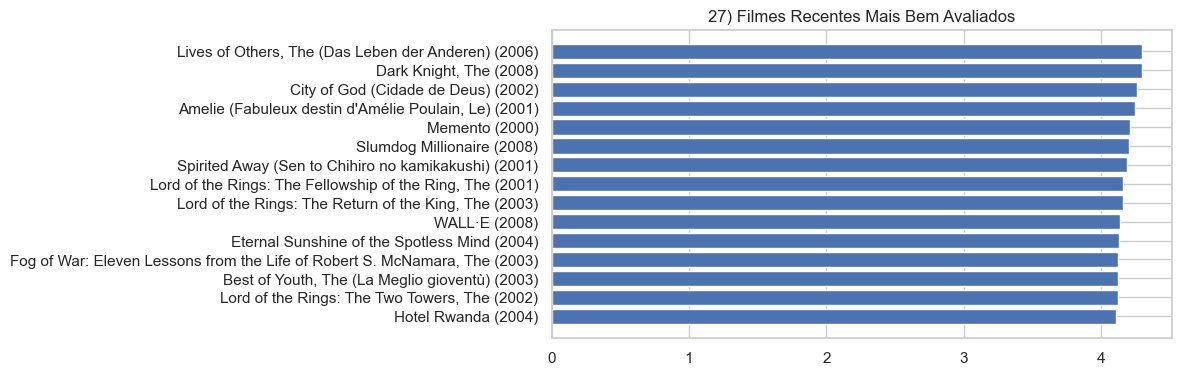


=== 28) Nota m√©dia por d√©cada ===
shape: (94, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ decade ‚îÜ avg_rating ‚îÇ
‚îÇ ---    ‚îÜ ---        ‚îÇ
‚îÇ f64    ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1915.0 ‚îÜ 3.248768   ‚îÇ
‚îÇ 1916.0 ‚îÜ 3.767327   ‚îÇ
‚îÇ 1917.0 ‚îÜ 3.805556   ‚îÇ
‚îÇ 1918.0 ‚îÜ 3.646341   ‚îÇ
‚îÇ 1919.0 ‚îÜ 3.308743   ‚îÇ
‚îÇ ‚Ä¶      ‚îÜ ‚Ä¶          ‚îÇ
‚îÇ 2004.0 ‚îÜ 3.531266   ‚îÇ
‚îÇ 2005.0 ‚îÜ 3.479449   ‚îÇ
‚îÇ 2006.0 ‚îÜ 3.535545   ‚îÇ
‚îÇ 2007.0 ‚îÜ 3.5289     ‚îÇ
‚îÇ 2008.0 ‚îÜ 3.458922   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


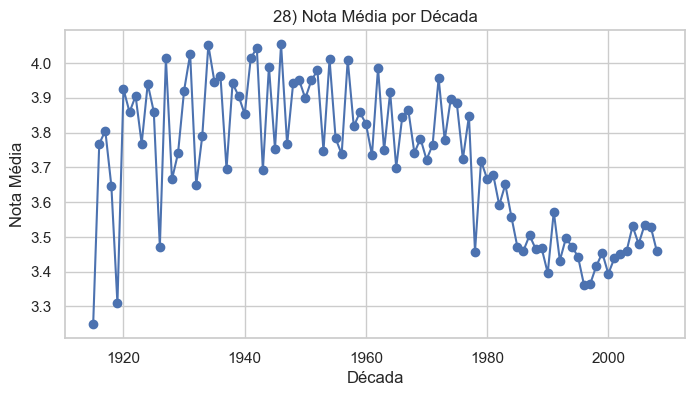


=== 29) N¬∫ de g√™neros por filme ===
shape: (9, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ movieId      ‚îÜ n_genres ‚îÇ
‚îÇ ---        ‚îÜ ---          ‚îÜ ---      ‚îÇ
‚îÇ str        ‚îÜ f64          ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 10680.0      ‚îÜ 10680.0  ‚îÇ
‚îÇ null_count ‚îÜ 0.0          ‚îÜ 0.0      ‚îÇ
‚îÇ mean       ‚îÜ 13120.946255 ‚îÜ 2.019007 ‚îÇ
‚îÇ std        ‚îÜ 17809.62936  ‚îÜ 1.029172 ‚îÇ
‚îÇ min        ‚îÜ 1.0          ‚îÜ 1.0      ‚îÇ
‚îÇ 25%        ‚îÜ 2755.0       ‚îÜ 1.0      ‚îÇ
‚îÇ 50%        ‚îÜ 5436.0       ‚îÜ 2.0      ‚îÇ
‚îÇ 75%        ‚îÜ 8713.0       ‚îÜ 3.0      ‚îÇ
‚îÇ max        ‚îÜ 65133.0      ‚îÜ 8.0      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

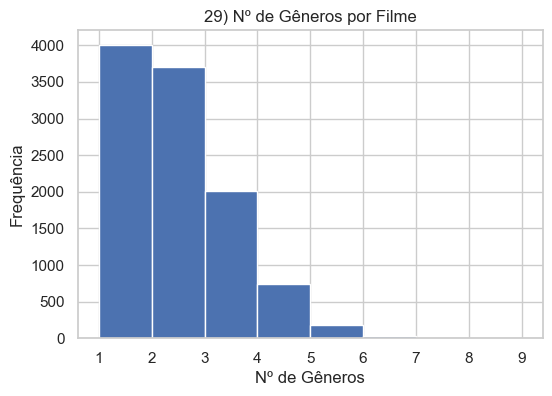


=== 30) Filmes com mais g√™neros ===
shape: (15, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n_genres ‚îÇ
‚îÇ ---                             ‚îÜ ---      ‚îÇ
‚îÇ str                             ‚îÜ i64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Host, The (Gwoemul) (2006)      ‚îÜ 8        ‚îÇ
‚îÇ Enchanted (2007)                ‚îÜ 7        ‚îÇ
‚îÇ Who Framed Roger Rabbit? (1988‚Ä¶ ‚îÜ 7        ‚îÇ
‚îÇ Monster House (2006)            ‚îÜ 7        ‚îÇ
‚îÇ Meet the Robinsons (2007)       ‚îÜ 6        ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶        ‚îÇ
‚îÇ Return of Jafar, The (1994)     ‚îÜ 6        ‚îÇ
‚îÇ Song of the Thin Man (1947)     ‚îÜ 6        ‚îÇ
‚îÇ Battlestar Galactica: Razor (2‚Ä¶ ‚îÜ 6        ‚îÇ
‚îÇ Holy Mountain, The (M

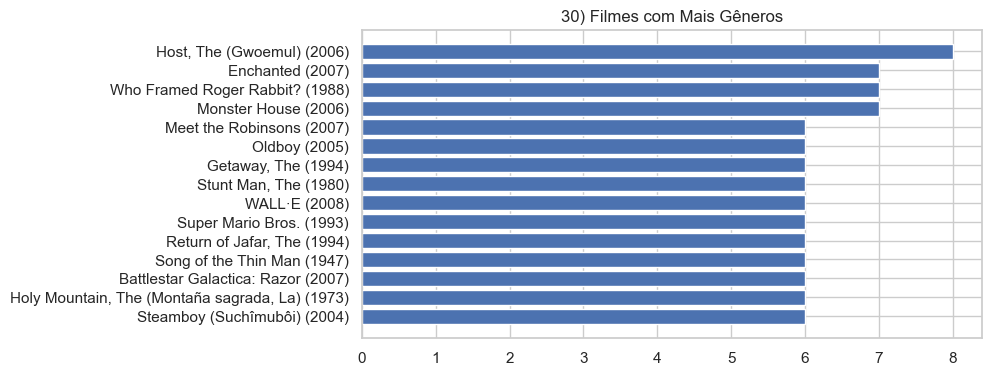

In [68]:
# 21) Filmes mais consensuais (menor desvio padr√£o)
stat21 = q("""
    SELECT m.title, COUNT(r.rating) AS n, STDDEV(r.rating) AS std
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 500
    ORDER BY std ASC
    LIMIT 15
""")
print("=== 21) Filmes mais consensuais ===")
print(stat21)
plt.figure(figsize=(8,4))
plt.barh(stat21["title"], stat21["std"])
plt.title("21) Filmes Mais Consensuais")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "21_filmes_consensuais.png"))
plt.show()

# 22) N¬∫ de tags por usu√°rio
stat22 = q("""
    SELECT userId, COUNT(*) AS n_tags
    FROM tags
    GROUP BY userId
""")
print("\n=== 22) N¬∫ de tags por usu√°rio ===")
print(stat22.describe())
plt.figure(figsize=(6,4))
plt.hist(stat22["n_tags"], bins=50, log=True)
plt.title("22) N¬∫ de Tags por Usu√°rio")
plt.xlabel("N¬∫ de Tags")
plt.ylabel("Frequ√™ncia (log)")
plt.savefig(os.path.join(output_dir, "22_tags_usuario.png"))
plt.show()

# 23) Tags mais associadas a notas altas (‚â•4)
stat23 = q("""
    SELECT LOWER(TRIM(t.tag)) AS tag, AVG(r.rating) AS avg_rating, COUNT(*) AS n
    FROM ratings r
    JOIN tags t USING (userId, movieId)
    GROUP BY tag
    HAVING COUNT(*) >= 50
    ORDER BY avg_rating DESC
    LIMIT 20
""")
print("\n=== 23) Tags mais associadas a notas altas ===")
print(stat23)
plt.figure(figsize=(8,4))
plt.barh(stat23["tag"], stat23["avg_rating"])
plt.title("23) Tags Associadas a Notas Altas")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "23_tags_altas.png"))
plt.show()

# 24) Tags mais associadas a notas baixas (‚â§2)
stat24 = q("""
    SELECT LOWER(TRIM(t.tag)) AS tag, AVG(r.rating) AS avg_rating, COUNT(*) AS n
    FROM ratings r
    JOIN tags t USING (userId, movieId)
    GROUP BY tag
    HAVING COUNT(*) >= 50
    ORDER BY avg_rating ASC
    LIMIT 20
""")
print("\n=== 24) Tags mais associadas a notas baixas ===")
print(stat24)
plt.figure(figsize=(8,4))
plt.barh(stat24["tag"], stat24["avg_rating"])
plt.title("24) Tags Associadas a Notas Baixas")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "24_tags_baixas.png"))
plt.show()

# 25) Evolu√ß√£o da nota m√©dia por g√™nero (exemplo)
stat25 = q("""
    WITH exploded AS (
        SELECT r.rating, DATE_TRUNC('year', TO_TIMESTAMP(r.timestamp)) AS year,
               UNNEST(STRING_SPLIT(m.genres, '|')) AS genre
        FROM ratings r
        JOIN movies m USING (movieId)
        WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    )
    SELECT year, genre, AVG(rating) AS avg_rating
    FROM exploded
    GROUP BY year, genre
    ORDER BY year, genre
""")
print("\n=== 25) Evolu√ß√£o da nota m√©dia por g√™nero (amostra) ===")
print(stat25.head(20))
plt.figure(figsize=(10,5))
for g in stat25["genre"].unique()[:5]:  # plota s√≥ alguns g√™neros
    subset = stat25.filter(stat25["genre"] == g)
    plt.plot(subset["year"], subset["avg_rating"], label=g)
plt.legend()
plt.title("25) Evolu√ß√£o da Nota M√©dia por G√™nero (amostra)")
plt.xlabel("Ano")
plt.ylabel("Nota M√©dia")
plt.savefig(os.path.join(output_dir, "25_evolucao_genero.png"))
plt.show()

# 26) Cl√°ssicos antigos mais bem avaliados (antes de 1960)
stat26 = q("""
    SELECT m.title, AVG(r.rating) AS avg_rating, COUNT(r.rating) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE m.title LIKE '%(19%' AND CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) < 1960
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 100
    ORDER BY avg_rating DESC
    LIMIT 15
""")
print("\n=== 26) Cl√°ssicos antigos mais bem avaliados ===")
print(stat26)
plt.figure(figsize=(8,4))
plt.barh(stat26["title"], stat26["avg_rating"])
plt.title("26) Cl√°ssicos Antigos Mais Bem Avaliados")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "26_classicos_antigos.png"))
plt.show()

# 27) Filmes recentes mais bem avaliados (2000+)
stat27 = q("""
    SELECT m.title, AVG(r.rating) AS avg_rating, COUNT(r.rating) AS n
    FROM ratings r
    JOIN movies m USING (movieId)
    WHERE CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT) >= 2000
    GROUP BY m.title
    HAVING COUNT(r.rating) >= 100
    ORDER BY avg_rating DESC
    LIMIT 15
""")
print("\n=== 27) Filmes recentes mais bem avaliados ===")
print(stat27)
plt.figure(figsize=(8,4))
plt.barh(stat27["title"], stat27["avg_rating"])
plt.title("27) Filmes Recentes Mais Bem Avaliados")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "27_filmes_recentes.png"))
plt.show()

# 28) Nota m√©dia por d√©cada
stat28 = q("""
    SELECT (CAST(SUBSTRING(m.title, LENGTH(m.title)-4, 4) AS INT)/10)*10 AS decade,
           AVG(r.rating) AS avg_rating
    FROM movies m
    JOIN ratings r USING (movieId)
    WHERE m.title LIKE '%(%)'
    GROUP BY decade
    ORDER BY decade
""")
print("\n=== 28) Nota m√©dia por d√©cada ===")
print(stat28)
plt.figure(figsize=(8,4))
plt.plot(stat28["decade"], stat28["avg_rating"], marker="o")
plt.title("28) Nota M√©dia por D√©cada")
plt.xlabel("D√©cada")
plt.ylabel("Nota M√©dia")
plt.savefig(os.path.join(output_dir, "28_media_decada.png"))
plt.show()

# 29) N¬∫ de g√™neros por filme
stat29 = q("""
    SELECT movieId, COUNT(*) AS n_genres
    FROM (
        SELECT movieId, UNNEST(STRING_SPLIT(genres, '|')) AS genre
        FROM movies
        WHERE genres IS NOT NULL AND genres <> '(no genres listed)'
    )
    GROUP BY movieId
""")
print("\n=== 29) N¬∫ de g√™neros por filme ===")
print(stat29.describe())
plt.figure(figsize=(6,4))
plt.hist(stat29["n_genres"], bins=range(1,10))
plt.title("29) N¬∫ de G√™neros por Filme")
plt.xlabel("N¬∫ de G√™neros")
plt.ylabel("Frequ√™ncia")
plt.savefig(os.path.join(output_dir, "29_generos_filme.png"))
plt.show()

# 30) Filmes com mais g√™neros
stat30 = q("""
    SELECT m.title, COUNT(*) AS n_genres
    FROM movies m,
         UNNEST(STRING_SPLIT(m.genres, '|')) g
    WHERE m.genres IS NOT NULL AND m.genres <> '(no genres listed)'
    GROUP BY m.title
    ORDER BY n_genres DESC
    LIMIT 15
""")
print("\n=== 30) Filmes com mais g√™neros ===")
print(stat30)
plt.figure(figsize=(8,4))
plt.barh(stat30["title"], stat30["n_genres"])
plt.title("30) Filmes com Mais G√™neros")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "30_filmes_multigenero.png"))
plt.show()


=== 31) Distribui√ß√£o de notas por d√©cada ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ decade ‚îÜ rating ‚îÜ n   ‚îÇ
‚îÇ ---    ‚îÜ ---    ‚îÜ --- ‚îÇ
‚îÇ f64    ‚îÜ f64    ‚îÜ i64 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1915.0 ‚îÜ 0.5    ‚îÜ 14  ‚îÇ
‚îÇ 1915.0 ‚îÜ 1.0    ‚îÜ 7   ‚îÇ
‚îÇ 1915.0 ‚îÜ 1.5    ‚îÜ 5   ‚îÇ
‚îÇ 1915.0 ‚îÜ 2.0    ‚îÜ 12  ‚îÇ
‚îÇ 1915.0 ‚îÜ 2.5    ‚îÜ 14  ‚îÇ
‚îÇ ‚Ä¶      ‚îÜ ‚Ä¶      ‚îÜ ‚Ä¶   ‚îÇ
‚îÇ 1916.0 ‚îÜ 4.0    ‚îÜ 24  ‚îÇ
‚îÇ 1916.0 ‚îÜ 4.5    ‚îÜ 16  ‚îÇ
‚îÇ 1916.0 ‚îÜ 5.0    ‚îÜ 16  ‚îÇ
‚îÇ 1917.0 ‚îÜ 0.5    ‚îÜ 1   ‚îÇ
‚îÇ 1917.0 ‚îÜ 2.0    ‚îÜ 1   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


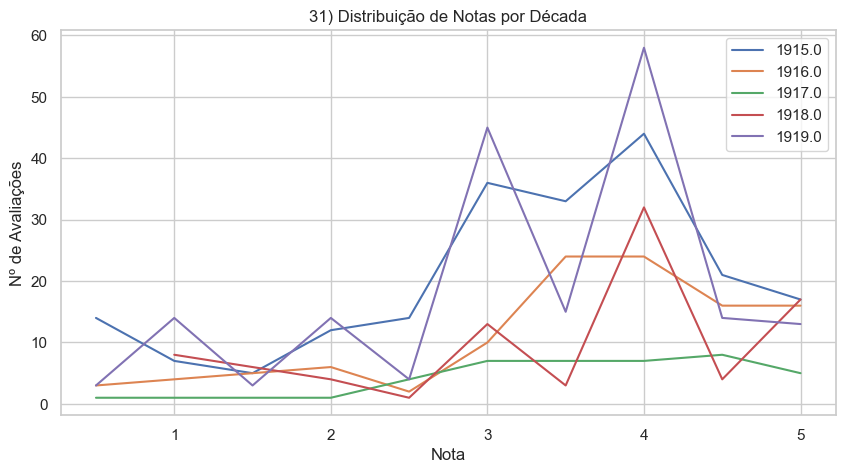


=== 32) Filme mais avaliado por d√©cada (Top 1 por d√©cada) ===
   decade                                              title  n_ratings
0    1910                      Birth of a Nation, The (1915)        203
1    1920                                  Metropolis (1927)       2733
2    1930                           Wizard of Oz, The (1939)      12851
3    1940                                  Casablanca (1942)      12507
4    1950                                 Rear Window (1954)       8825
5    1960                       2001: A Space Odyssey (1968)      13061
6    1970  Star Wars: Episode IV - A New Hope (a.k.a. Sta...      28566
7    1980                                      Batman (1989)      26996
8    1990                                Pulp Fiction (1994)      34864
9    2000  Lord of the Rings: The Fellowship of the Ring,...      15938


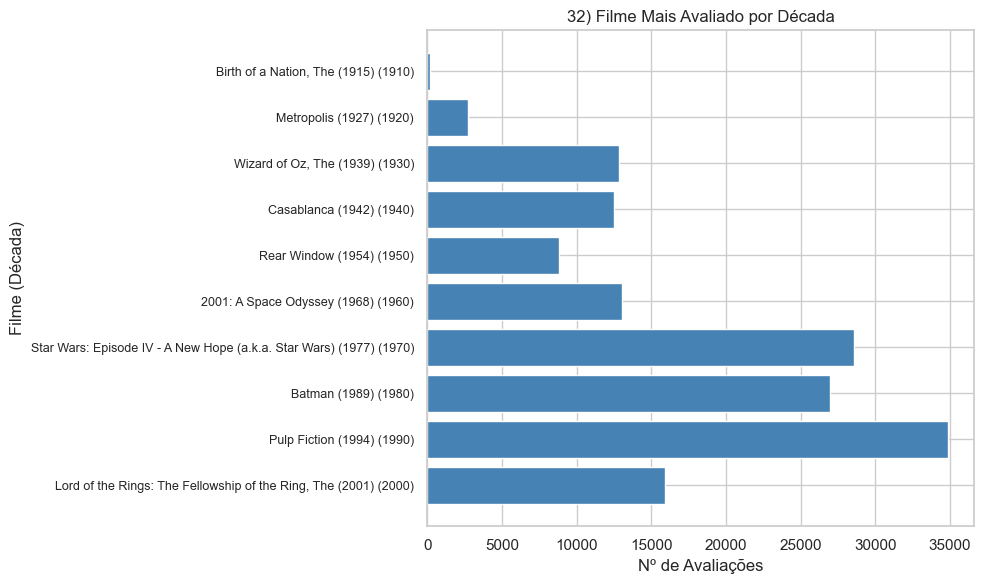


=== 33) Filmes com maior propor√ß√£o de notas 5 ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ prop_5   ‚îÜ n     ‚îÇ
‚îÇ ---                             ‚îÜ ---      ‚îÜ ---   ‚îÇ
‚îÇ str                             ‚îÜ f64      ‚îÜ i64   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Godfather, The (1972)           ‚îÜ 0.532603 ‚îÜ 19814 ‚îÇ
‚îÇ Shawshank Redemption, The (199‚Ä¶ ‚îÜ 0.528818 ‚îÜ 31126 ‚îÇ
‚îÇ World of Apu, The (Apur Sansar‚Ä¶ ‚îÜ 0.498818 ‚îÜ 423   ‚îÇ
‚îÇ Schindler's List (1993)         ‚îÜ 0.497071 ‚îÜ 25777 ‚îÇ
‚îÇ Children of Paradise (Les enfa‚Ä¶ ‚îÜ 0.479204 ‚îÜ 553   ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ Wallace & Gromit: The B

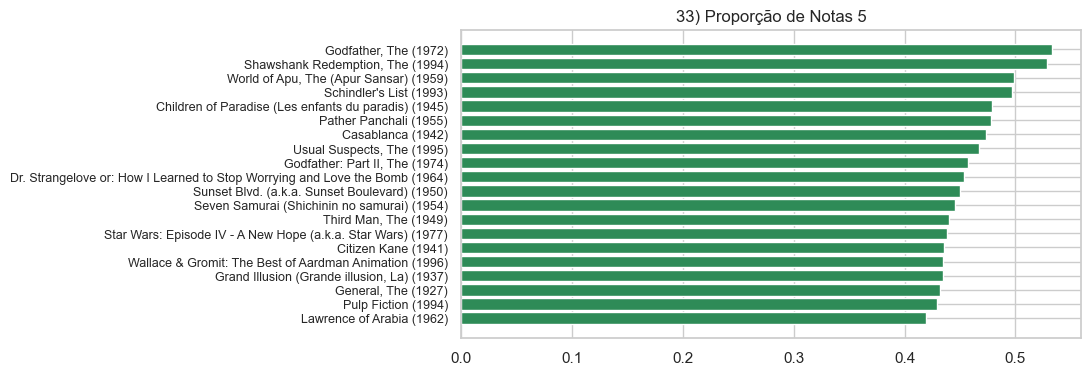


=== 34) Filmes com maior propor√ß√£o de notas 0.5 ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ prop_05  ‚îÜ n   ‚îÇ
‚îÇ ---                             ‚îÜ ---      ‚îÜ --- ‚îÇ
‚îÇ str                             ‚îÜ f64      ‚îÜ i64 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ From Justin to Kelly (2003)     ‚îÜ 0.643519 ‚îÜ 216 ‚îÇ
‚îÇ Pokemon 4 Ever (a.k.a. Pok√©mon‚Ä¶ ‚îÜ 0.570815 ‚îÜ 233 ‚îÇ
‚îÇ Gigli (2003)                    ‚îÜ 0.485795 ‚îÜ 352 ‚îÇ
‚îÇ House of the Dead, The (2003)   ‚îÜ 0.411255 ‚îÜ 231 ‚îÇ
‚îÇ Glitter (2001)                  ‚îÜ 0.355263 ‚îÜ 380 ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶   ‚îÇ
‚îÇ Turbo: A Power Rangers Movie (‚Ä¶ ‚îÜ 0.229545 ‚îÜ 440

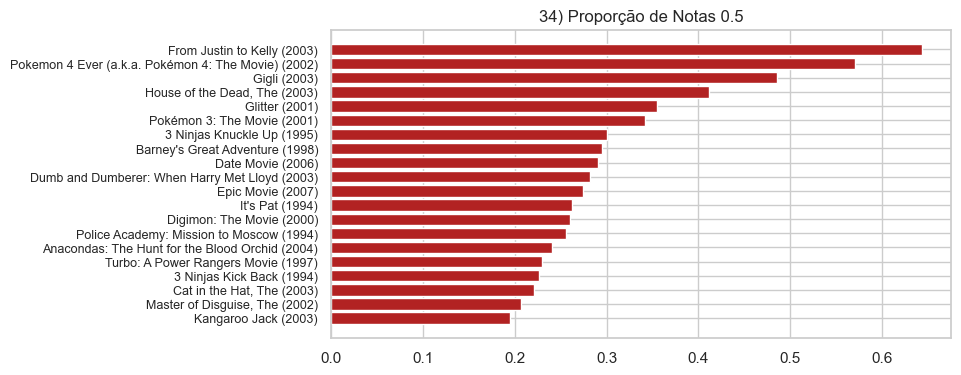


=== 35) Usu√°rios que mais usam notas extremas ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ userId ‚îÜ prop_extremas ‚îÜ n   ‚îÇ
‚îÇ ---    ‚îÜ ---           ‚îÜ --- ‚îÇ
‚îÇ i64    ‚îÜ f64           ‚îÜ i64 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 36022  ‚îÜ 0.981818      ‚îÜ 110 ‚îÇ
‚îÇ 5763   ‚îÜ 0.942149      ‚îÜ 242 ‚îÇ
‚îÇ 36896  ‚îÜ 0.939394      ‚îÜ 165 ‚îÇ
‚îÇ 48518  ‚îÜ 0.92          ‚îÜ 150 ‚îÇ
‚îÇ 7605   ‚îÜ 0.917431      ‚îÜ 109 ‚îÇ
‚îÇ ‚Ä¶      ‚îÜ ‚Ä¶             ‚îÜ ‚Ä¶   ‚îÇ
‚îÇ 11571  ‚îÜ 0.863309      ‚îÜ 139 ‚îÇ
‚îÇ 62537  ‚îÜ 0.854077      ‚îÜ 233 ‚îÇ
‚îÇ 56443  ‚îÜ 0.853333      ‚îÜ 150 ‚îÇ
‚îÇ 24193  ‚îÜ 0.852174      ‚îÜ 115 ‚îÇ
‚îÇ 60907  ‚îÜ 0.850932      ‚îÜ 161 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


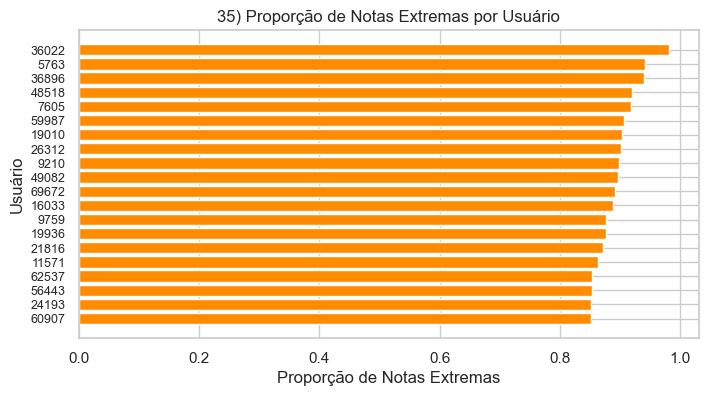


=== 36) Heatmap hora x dia da semana ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ dow ‚îÜ hour ‚îÜ n     ‚îÇ
‚îÇ --- ‚îÜ ---  ‚îÜ ---   ‚îÇ
‚îÇ i64 ‚îÜ i64  ‚îÜ i64   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0   ‚îÜ 0    ‚îÜ 67108 ‚îÇ
‚îÇ 0   ‚îÜ 1    ‚îÜ 66748 ‚îÇ
‚îÇ 0   ‚îÜ 2    ‚îÜ 63094 ‚îÇ
‚îÇ 0   ‚îÜ 3    ‚îÜ 63431 ‚îÇ
‚îÇ 0   ‚îÜ 4    ‚îÜ 61941 ‚îÇ
‚îÇ ‚Ä¶   ‚îÜ ‚Ä¶    ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ 0   ‚îÜ 15   ‚îÜ 50409 ‚îÇ
‚îÇ 0   ‚îÜ 16   ‚îÜ 63718 ‚îÇ
‚îÇ 0   ‚îÜ 17   ‚îÜ 70416 ‚îÇ
‚îÇ 0   ‚îÜ 18   ‚îÜ 68903 ‚îÇ
‚îÇ 0   ‚îÜ 19   ‚îÜ 78718 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


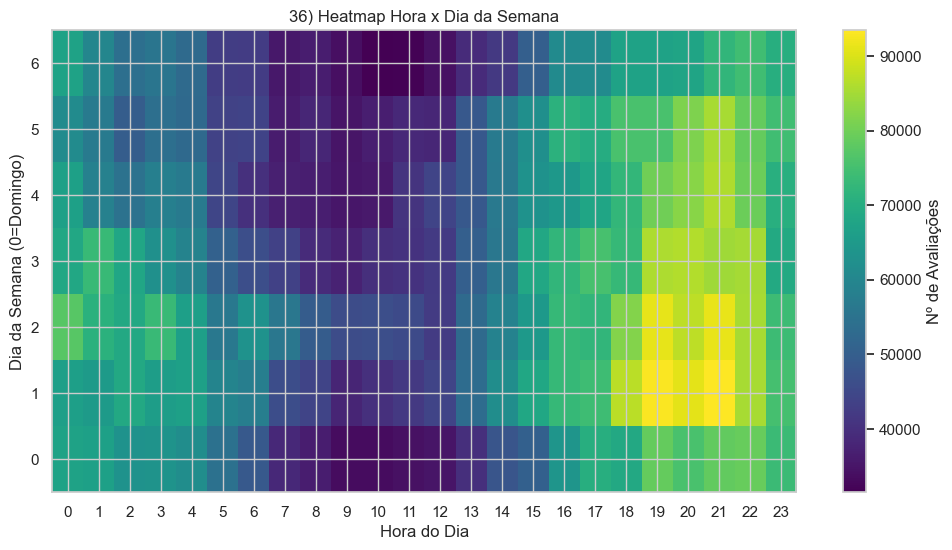


=== 37) Filmes mais tagueados ===
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n_tags ‚îÇ
‚îÇ ---                             ‚îÜ ---    ‚îÇ
‚îÇ str                             ‚îÜ i64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Pulp Fiction (1994)             ‚îÜ 308    ‚îÇ
‚îÇ Shawshank Redemption, The (199‚Ä¶ ‚îÜ 257    ‚îÇ
‚îÇ Fight Club (1999)               ‚îÜ 235    ‚îÇ
‚îÇ Schindler's List (1993)         ‚îÜ 232    ‚îÇ
‚îÇ Matrix, The (1999)              ‚îÜ 223    ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶      ‚îÇ
‚îÇ Amelie (Fabuleux destin d'Am√©l‚Ä¶ ‚îÜ 183    ‚îÇ
‚îÇ City of God (Cidade de Deus) (‚Ä¶ ‚îÜ 183    ‚îÇ
‚îÇ Serenity (2005)                 ‚îÜ 181    ‚îÇ
‚îÇ Memento (2000)                  ‚îÜ 179    ‚îÇ
‚îÇ Seven 

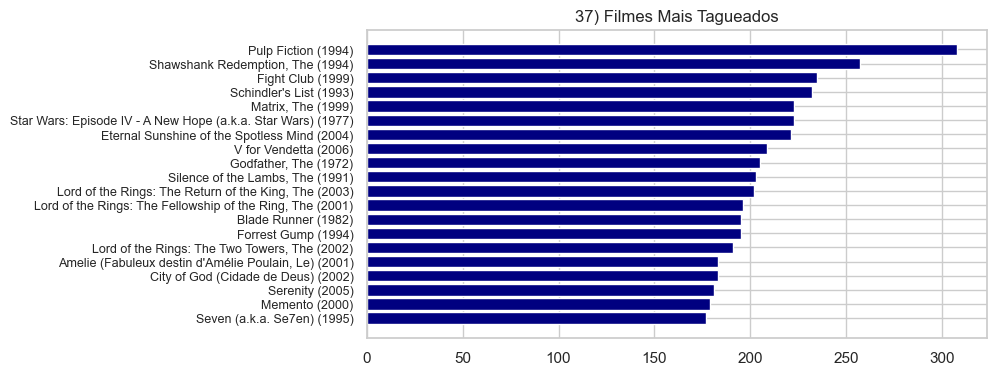


=== 38) Tag mais popular por d√©cada (Top 1 por d√©cada) ===
   decade                              tag    n
0    1910  white film theory and criticism    2
1    1920                          classic    5
2    1930                          classic   29
3    1940                           disney   22
4    1950                          classic   17
5    1960                          classic   21
6    1970                           sci-fi   20
7    1980                            anime   37
8    1990                quentin tarantino   42
9    2000                                r  111


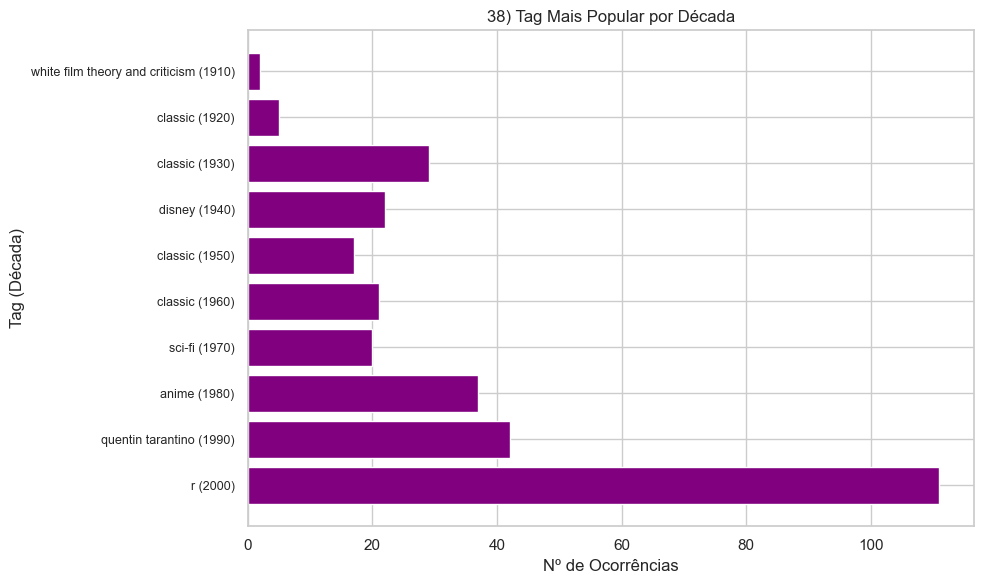


=== 39) Filmes com maior varia√ß√£o de notas ao longo do tempo ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ std_time ‚îÜ n_periods ‚îÇ
‚îÇ ---                             ‚îÜ ---      ‚îÜ ---       ‚îÇ
‚îÇ str                             ‚îÜ f64      ‚îÜ i64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Madagascar Skin (1995)          ‚îÜ 1.752792 ‚îÜ 6         ‚îÇ
‚îÇ Alley Cats, The (1966)          ‚îÜ 1.635543 ‚îÜ 5         ‚îÇ
‚îÇ Tainted (1998)                  ‚îÜ 1.635543 ‚îÜ 6         ‚îÇ
‚îÇ Letter From Death Row, A (1998‚Ä¶ ‚îÜ 1.624181 ‚îÜ 6         ‚îÇ
‚îÇ Haunted Castle (2001)           ‚îÜ 1.615983 ‚îÜ 6         ‚îÇ
‚îÇ ‚Ä¶                      

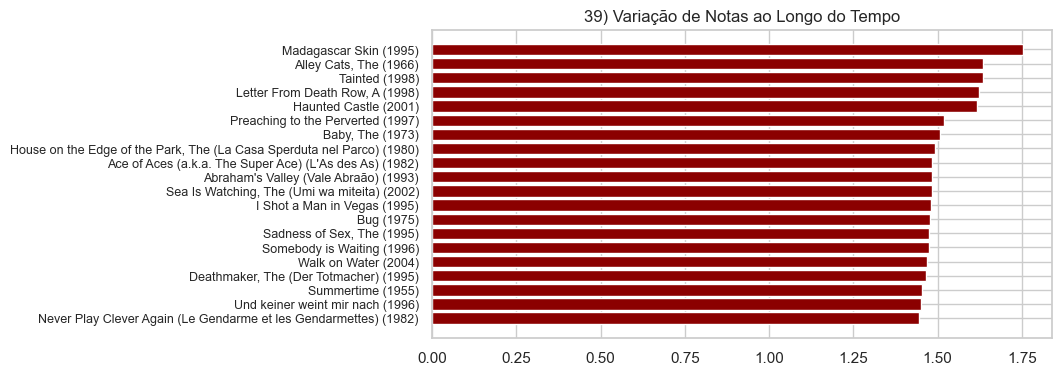


=== 40) Evolu√ß√£o da quantidade de tags ao longo do tempo ===
shape: (5, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ano                         ‚îÜ n_tags ‚îÇ
‚îÇ ---                         ‚îÜ ---    ‚îÇ
‚îÇ datetime[Œºs, Europe/London] ‚îÜ i64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2005-01-01 00:00:00 GMT     ‚îÜ 38     ‚îÇ
‚îÇ 2006-01-01 00:00:00 GMT     ‚îÜ 36163  ‚îÇ
‚îÇ 2007-01-01 00:00:00 GMT     ‚îÜ 36395  ‚îÇ
‚îÇ 2008-01-01 00:00:00 GMT     ‚îÜ 22674  ‚îÇ
‚îÇ 2009-01-01 00:00:00 GMT     ‚îÜ 310    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


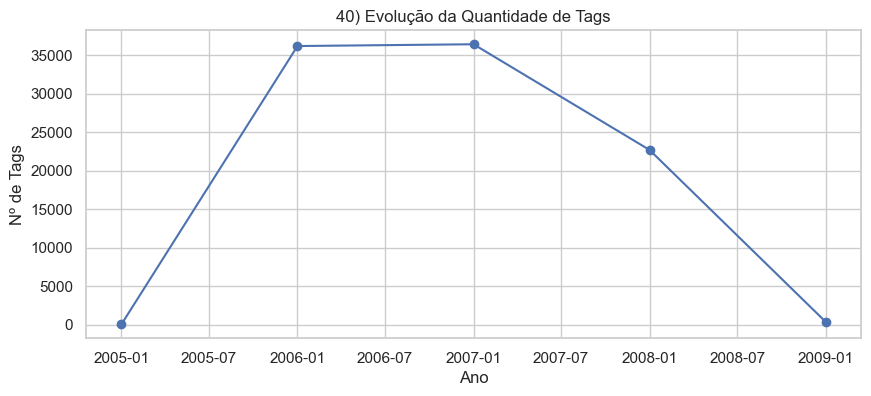


=== 41) Filmes mais avaliados em finais de semana ===
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n    ‚îÇ
‚îÇ ---                             ‚îÜ ---  ‚îÇ
‚îÇ str                             ‚îÜ i64  ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Pulp Fiction (1994)             ‚îÜ 8775 ‚îÇ
‚îÇ Forrest Gump (1994)             ‚îÜ 8768 ‚îÇ
‚îÇ Silence of the Lambs, The (199‚Ä¶ ‚îÜ 8500 ‚îÇ
‚îÇ Jurassic Park (1993)            ‚îÜ 8264 ‚îÇ
‚îÇ Shawshank Redemption, The (199‚Ä¶ ‚îÜ 7945 ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶    ‚îÇ
‚îÇ Star Wars: Episode VI - Return‚Ä¶ ‚îÜ 6382 ‚îÇ
‚îÇ True Lies (1994)                ‚îÜ 6359 ‚îÇ
‚îÇ Fargo (1996)                    ‚îÜ 6224 ‚îÇ
‚îÇ Matrix, The (1999)              ‚îÜ 6024 ‚îÇ
‚îÇ 12 Monkeys (Twelve Monkey

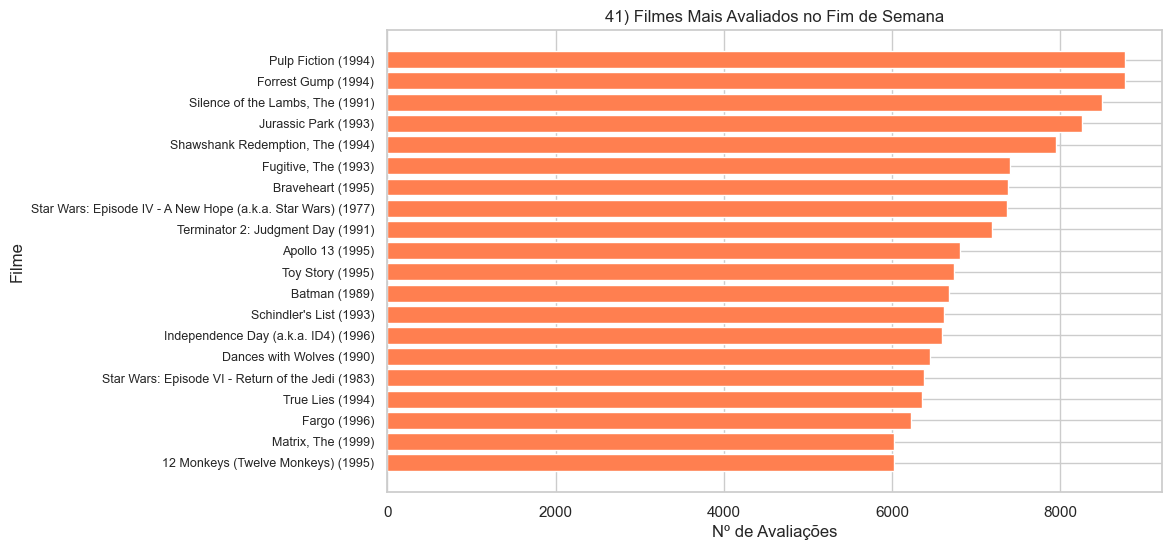


=== 42) Filmes mais avaliados em dias √∫teis ===
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ n     ‚îÇ
‚îÇ ---                             ‚îÜ ---   ‚îÇ
‚îÇ str                             ‚îÜ i64   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Pulp Fiction (1994)             ‚îÜ 26089 ‚îÇ
‚îÇ Forrest Gump (1994)             ‚îÜ 25689 ‚îÇ
‚îÇ Silence of the Lambs, The (199‚Ä¶ ‚îÜ 25168 ‚îÇ
‚îÇ Jurassic Park (1993)            ‚îÜ 24367 ‚îÇ
‚îÇ Shawshank Redemption, The (199‚Ä¶ ‚îÜ 23181 ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶     ‚îÇ
‚îÇ True Lies (1994)                ‚îÜ 19022 ‚îÇ
‚îÇ Star Wars: Episode VI - Return‚Ä¶ ‚îÜ 18716 ‚îÇ
‚îÇ 12 Monkeys (Twelve Monkeys) (1‚Ä¶ ‚îÜ 18379 ‚îÇ
‚îÇ Usual Suspects, The (1995)      ‚îÜ 18063 ‚îÇ
‚îÇ Speed (19

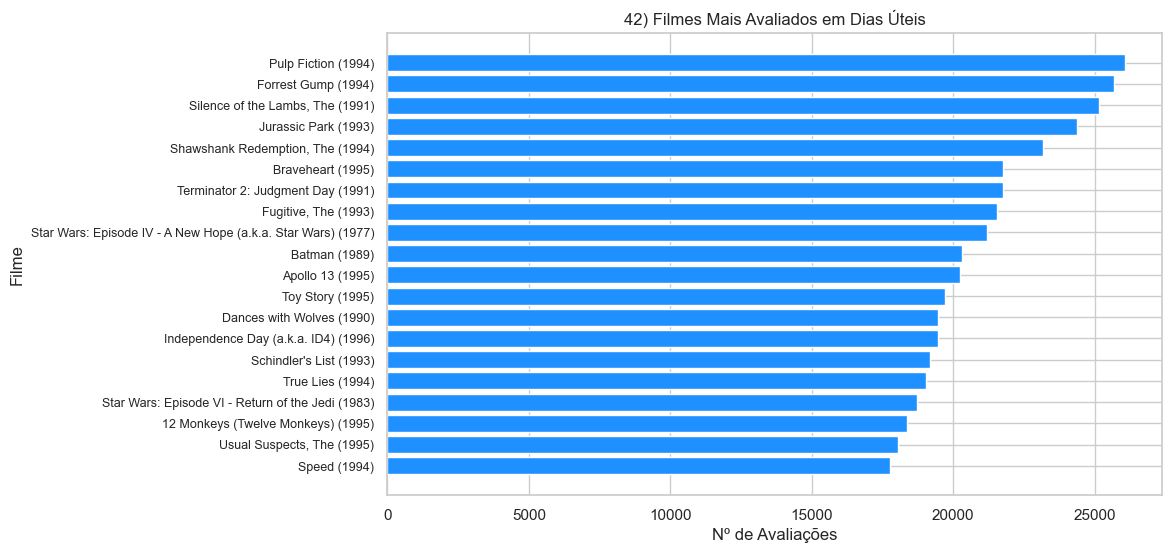


=== 43) Diferen√ßa de m√©dia semana vs fim de semana ===
shape: (20, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ avg_semana ‚îÜ avg_fds  ‚îÜ diff      ‚îÇ
‚îÇ ---                             ‚îÜ ---        ‚îÜ ---      ‚îÜ ---       ‚îÇ
‚îÇ str                             ‚îÜ f64        ‚îÜ f64      ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Texas Chainsaw Massacre, The (‚Ä¶ ‚îÜ 2.840404   ‚îÜ 2.511976 ‚îÜ -0.328428 ‚îÇ
‚îÇ Boy Who Could Fly, The (1986)   ‚îÜ 2.986438   ‚îÜ 3.288557 ‚îÜ 0.30212   ‚îÇ
‚îÇ Halloween III: Season of the W‚Ä¶ ‚îÜ 1.791667   ‚îÜ 2.092308 ‚îÜ 0.300641  ‚îÇ
‚îÇ

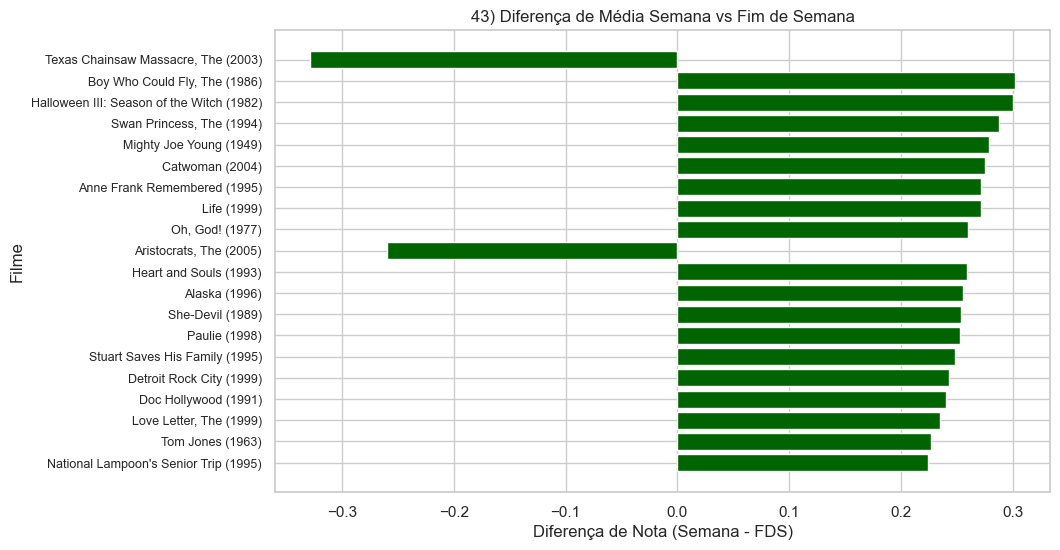


=== 44) Filmes com maior crescimento de avalia√ß√µes ===
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ crescimento ‚îÇ
‚îÇ ---                             ‚îÜ ---         ‚îÇ
‚îÇ str                             ‚îÜ i64         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Batman (1989)                   ‚îÜ 13350       ‚îÇ
‚îÇ Dances with Wolves (1990)       ‚îÜ 12732       ‚îÇ
‚îÇ Apollo 13 (1995)                ‚îÜ 12693       ‚îÇ
‚îÇ Fugitive, The (1993)            ‚îÜ 12127       ‚îÇ
‚îÇ True Lies (1994)                ‚îÜ 12036       ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶           ‚îÇ
‚îÇ Stargate (1994)                 ‚îÜ 9797        ‚îÇ
‚îÇ Shawshank Redemption, The (199‚Ä¶ ‚îÜ 9648        ‚îÇ
‚îÇ Outbr

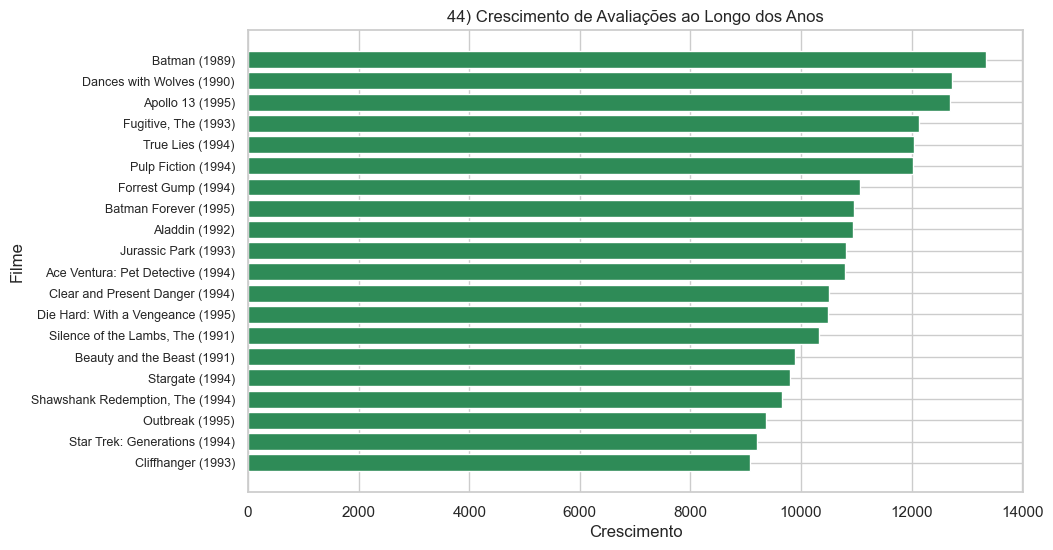


=== 45) Filmes com maior queda de popularidade ===
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ title                           ‚îÜ queda  ‚îÇ
‚îÇ ---                             ‚îÜ ---    ‚îÇ
‚îÇ str                             ‚îÜ i64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Batman (1989)                   ‚îÜ -13350 ‚îÇ
‚îÇ Dances with Wolves (1990)       ‚îÜ -12732 ‚îÇ
‚îÇ Apollo 13 (1995)                ‚îÜ -12693 ‚îÇ
‚îÇ Fugitive, The (1993)            ‚îÜ -12127 ‚îÇ
‚îÇ True Lies (1994)                ‚îÜ -12036 ‚îÇ
‚îÇ ‚Ä¶                               ‚îÜ ‚Ä¶      ‚îÇ
‚îÇ Stargate (1994)                 ‚îÜ -9797  ‚îÇ
‚îÇ Shawshank Redemption, The (199‚Ä¶ ‚îÜ -9648  ‚îÇ
‚îÇ Outbreak (1995)                 ‚îÜ -9368  ‚îÇ
‚îÇ Star Trek: Generations (1994)   ‚îÜ -9207  ‚î

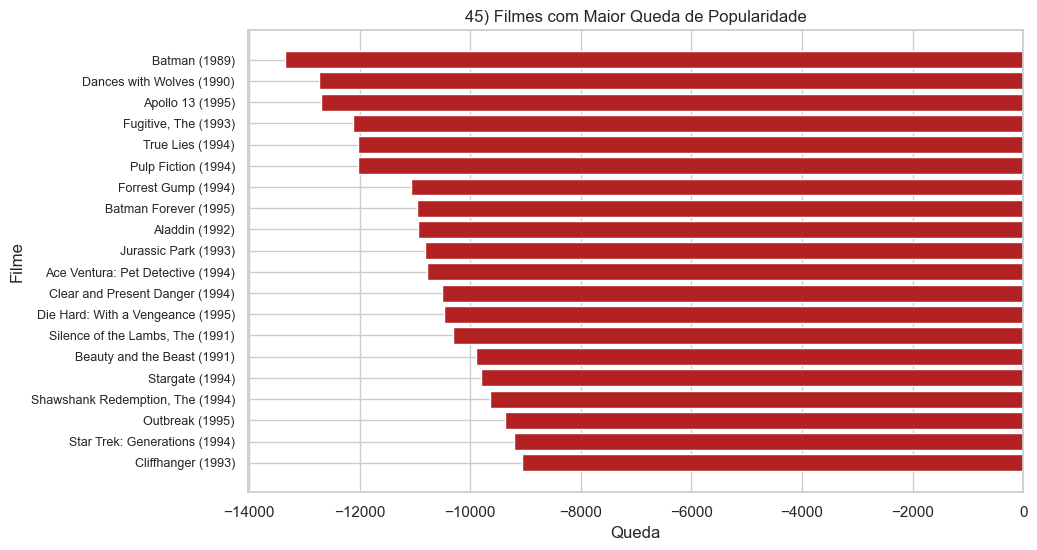


=== 46) Usu√°rios mais consistentes ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ userId ‚îÜ std_user ‚îÜ n   ‚îÇ
‚îÇ ---    ‚îÜ ---      ‚îÜ --- ‚îÇ
‚îÇ i64    ‚îÜ f64      ‚îÜ i64 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 24176  ‚îÜ 0.0      ‚îÜ 147 ‚îÇ
‚îÇ 29110  ‚îÜ 0.0      ‚îÜ 203 ‚îÇ
‚îÇ 5763   ‚îÜ 0.258228 ‚îÜ 242 ‚îÇ
‚îÇ 47202  ‚îÜ 0.272561 ‚îÜ 157 ‚îÇ
‚îÇ 59987  ‚îÜ 0.331054 ‚îÜ 226 ‚îÇ
‚îÇ ‚Ä¶      ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶   ‚îÇ
‚îÇ 16713  ‚îÜ 0.383169 ‚îÜ 164 ‚îÇ
‚îÇ 23696  ‚îÜ 0.384688 ‚îÜ 119 ‚îÇ
‚îÇ 57740  ‚îÜ 0.385163 ‚îÜ 116 ‚îÇ
‚îÇ 47780  ‚îÜ 0.3889   ‚îÜ 120 ‚îÇ
‚îÇ 31677  ‚îÜ 0.395674 ‚îÜ 328 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


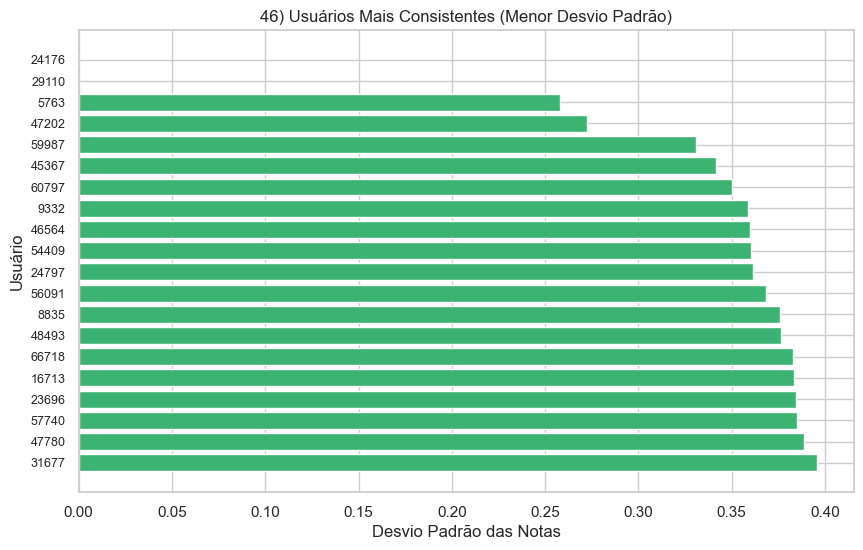


=== 47) Usu√°rios mais inconsistentes ===
shape: (20, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ userId ‚îÜ std_user ‚îÜ n    ‚îÇ
‚îÇ ---    ‚îÜ ---      ‚îÜ ---  ‚îÇ
‚îÇ i64    ‚îÜ f64      ‚îÜ i64  ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 62537  ‚îÜ 2.108368 ‚îÜ 233  ‚îÇ
‚îÇ 11760  ‚îÜ 2.040698 ‚îÜ 2213 ‚îÇ
‚îÇ 6925   ‚îÜ 1.984823 ‚îÜ 175  ‚îÇ
‚îÇ 70321  ‚îÜ 1.957742 ‚îÜ 432  ‚îÇ
‚îÇ 26312  ‚îÜ 1.944184 ‚îÜ 101  ‚îÇ
‚îÇ ‚Ä¶      ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶    ‚îÇ
‚îÇ 6369   ‚îÜ 1.796606 ‚îÜ 105  ‚îÇ
‚îÇ 16803  ‚îÜ 1.789627 ‚îÜ 104  ‚îÇ
‚îÇ 53844  ‚îÜ 1.787297 ‚îÜ 115  ‚îÇ
‚îÇ 17511  ‚îÜ 1.784302 ‚îÜ 259  ‚îÇ
‚îÇ 53046  ‚îÜ 1.783579 ‚îÜ 118  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


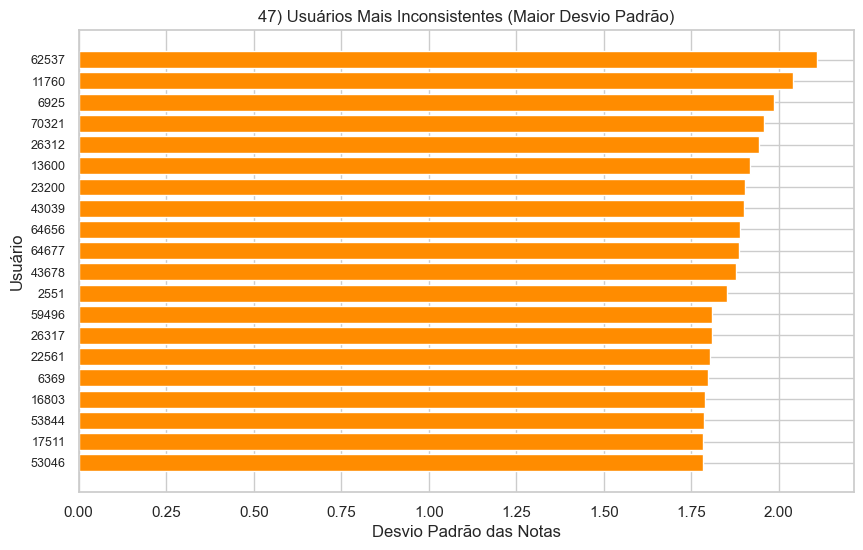

In [87]:
# 31) Distribui√ß√£o de notas por d√©cada
print("\n=== 31) Distribui√ß√£o de notas por d√©cada ===")
print(stat31.head(20))
plt.figure(figsize=(10,5))
for dec in stat31["decade"].unique()[:5]:
    subset = stat31.filter(stat31["decade"] == dec)
    plt.plot(subset["rating"], subset["n"], label=str(dec))
plt.legend()
plt.title("31) Distribui√ß√£o de Notas por D√©cada")
plt.xlabel("Nota")
plt.ylabel("N¬∫ de Avalia√ß√µes")
plt.savefig(os.path.join(output_dir, "31_notas_decada.png"))
plt.show()

# 32) Filme mais avaliado por d√©cada (Top 1 por d√©cada, Y = t√≠tulo + d√©cada)
print("\n=== 32) Filme mais avaliado por d√©cada (Top 1 por d√©cada) ===")
df32 = stat32.to_pandas().copy()

# garantir d√©cada correta
df32["decade"] = (df32["decade"] // 10 * 10).astype(int)

# pegar o filme mais avaliado em cada d√©cada
df32_top = df32.sort_values(["decade", "n_ratings"], ascending=[True, False]) \
               .groupby("decade", as_index=False).first()

# criar r√≥tulo "T√≠tulo (D√©cada)"
df32_top["label"] = df32_top["title"] + " (" + df32_top["decade"].astype(str) + ")"

print(df32_top[["decade","title","n_ratings"]])

plt.figure(figsize=(10,6))
y_pos = range(len(df32_top))
plt.barh(y_pos, df32_top["n_ratings"], color="steelblue")
plt.yticks(y_pos, df32_top["label"], fontsize=9)
plt.title("32) Filme Mais Avaliado por D√©cada")
plt.xlabel("N¬∫ de Avalia√ß√µes")
plt.ylabel("Filme (D√©cada)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "32_filmes_decada_top1.png"))
plt.show()

# 33) Filmes com maior propor√ß√£o de notas 5
print("\n=== 33) Filmes com maior propor√ß√£o de notas 5 ===")
print(stat33)
plt.figure(figsize=(8,4))
y_pos = range(len(stat33))
plt.barh(y_pos, stat33["prop_5"], color="seagreen")
plt.yticks(y_pos, stat33["title"], fontsize=9)
plt.title("33) Propor√ß√£o de Notas 5")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "33_prop5.png"))
plt.show()

# 34) Filmes com maior propor√ß√£o de notas 0.5
print("\n=== 34) Filmes com maior propor√ß√£o de notas 0.5 ===")
print(stat34)
plt.figure(figsize=(8,4))
y_pos = range(len(stat34))
plt.barh(y_pos, stat34["prop_05"], color="firebrick")
plt.yticks(y_pos, stat34["title"], fontsize=9)
plt.title("34) Propor√ß√£o de Notas 0.5")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "34_prop05.png"))
plt.show()

# 35) Usu√°rios que mais usam notas extremas
print("\n=== 35) Usu√°rios que mais usam notas extremas ===")
print(stat35)
df35 = stat35.to_pandas()
plt.figure(figsize=(8,4))
y_pos = range(len(df35))
plt.barh(y_pos, df35["prop_extremas"], color="darkorange")
plt.yticks(y_pos, df35["userId"].astype(str), fontsize=9)
plt.title("35) Propor√ß√£o de Notas Extremas por Usu√°rio")
plt.xlabel("Propor√ß√£o de Notas Extremas")
plt.ylabel("Usu√°rio")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "35_extremos.png"))
plt.show()

# 36) Heatmap hora x dia da semana
print("\n=== 36) Heatmap hora x dia da semana ===")
print(stat36.head(20))
pivot36 = stat36.to_pandas().pivot(index="dow", columns="hour", values="n")
plt.figure(figsize=(12,6))
plt.imshow(pivot36, aspect="auto", cmap="viridis", origin="lower")
plt.colorbar(label="N¬∫ de Avalia√ß√µes")
plt.xticks(range(len(pivot36.columns)), pivot36.columns)
plt.yticks(range(len(pivot36.index)), pivot36.index)
plt.title("36) Heatmap Hora x Dia da Semana")
plt.xlabel("Hora do Dia")
plt.ylabel("Dia da Semana (0=Domingo)")
plt.savefig(os.path.join(output_dir, "36_heatmap.png"))
plt.show()

# 37) Filmes mais tagueados
print("\n=== 37) Filmes mais tagueados ===")
print(stat37)
plt.figure(figsize=(8,4))
y_pos = range(len(stat37))
plt.barh(y_pos, stat37["n_tags"], color="navy")
plt.yticks(y_pos, stat37["title"], fontsize=9)
plt.title("37) Filmes Mais Tagueados")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "37_filmes_tagueados.png"))
plt.show()

# 38) Tag mais popular por d√©cada (Top 1 por d√©cada, Y = tag + d√©cada)
print("\n=== 38) Tag mais popular por d√©cada (Top 1 por d√©cada) ===")
df38 = stat38.to_pandas().copy()

# garantir d√©cada correta
df38["decade"] = (df38["decade"] // 10 * 10).astype(int)

# pegar a tag mais popular em cada d√©cada
df38_top = df38.sort_values(["decade", "n"], ascending=[True, False]) \
               .groupby("decade", as_index=False).first()

# criar r√≥tulo "Tag (D√©cada)"
df38_top["label"] = df38_top["tag"] + " (" + df38_top["decade"].astype(str) + ")"

print(df38_top[["decade","tag","n"]])

plt.figure(figsize=(10,6))
y_pos = range(len(df38_top))
plt.barh(y_pos, df38_top["n"], color="purple")
plt.yticks(y_pos, df38_top["label"], fontsize=9)
plt.title("38) Tag Mais Popular por D√©cada")
plt.xlabel("N¬∫ de Ocorr√™ncias")
plt.ylabel("Tag (D√©cada)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "38_tags_decada_top1.png"))
plt.show()
# 39) Filmes com maior varia√ß√£o de notas ao longo do tempo
print("\n=== 39) Filmes com maior varia√ß√£o de notas ao longo do tempo ===")
print(stat39)
plt.figure(figsize=(8,4))
y_pos = range(len(stat39))
plt.barh(y_pos, stat39["std_time"], color="darkred")
plt.yticks(y_pos, stat39["title"], fontsize=9)
plt.title("39) Varia√ß√£o de Notas ao Longo do Tempo")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "39_variacao_tempo.png"))
plt.show()

# 40) Evolu√ß√£o da quantidade de tags ao longo do tempo
print("\n=== 40) Evolu√ß√£o da quantidade de tags ao longo do tempo ===")
print(stat40.head(20))
plt.figure(figsize=(10,4))
plt.plot(stat40["ano"], stat40["n_tags"], marker="o")
plt.title("40) Evolu√ß√£o da Quantidade de Tags")
plt.xlabel("Ano")
plt.ylabel("N¬∫ de Tags")
plt.savefig(os.path.join(output_dir, "40_tags_tempo.png"))
plt.show()

# 41) Filmes mais avaliados em finais de semana
print("\n=== 41) Filmes mais avaliados em finais de semana ===")
print(stat44)
plt.figure(figsize=(10,6))
y_pos = range(len(stat44))
plt.barh(y_pos, stat44["n"], color="coral")
plt.yticks(y_pos, stat44["title"], fontsize=9)
plt.title("41) Filmes Mais Avaliados no Fim de Semana")
plt.xlabel("N¬∫ de Avalia√ß√µes")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "41_filmes_fds.png"))
plt.show()


# 42) Filmes mais avaliados em dias √∫teis
print("\n=== 42) Filmes mais avaliados em dias √∫teis ===")
print(stat45)
plt.figure(figsize=(10,6))
y_pos = range(len(stat45))
plt.barh(y_pos, stat45["n"], color="dodgerblue")
plt.yticks(y_pos, stat45["title"], fontsize=9)
plt.title("42) Filmes Mais Avaliados em Dias √öteis")
plt.xlabel("N¬∫ de Avalia√ß√µes")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "42_filmes_semana.png"))
plt.show()


# 43) Diferen√ßa de m√©dia semana vs fim de semana
print("\n=== 43) Diferen√ßa de m√©dia semana vs fim de semana ===")
print(stat46)
plt.figure(figsize=(10,6))
y_pos = range(len(stat46))
plt.barh(y_pos, stat46["diff"], color="darkgreen")
plt.yticks(y_pos, stat46["title"], fontsize=9)
plt.title("43) Diferen√ßa de M√©dia Semana vs Fim de Semana")
plt.xlabel("Diferen√ßa de Nota (Semana - FDS)")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "43_diff_semana_fds.png"))
plt.show()


# 44) Filmes com maior crescimento de avalia√ß√µes
print("\n=== 44) Filmes com maior crescimento de avalia√ß√µes ===")
print(stat47)
plt.figure(figsize=(10,6))
y_pos = range(len(stat47))
plt.barh(y_pos, stat47["crescimento"], color="seagreen")
plt.yticks(y_pos, stat47["title"], fontsize=9)
plt.title("44) Crescimento de Avalia√ß√µes ao Longo dos Anos")
plt.xlabel("Crescimento")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "44_crescimento.png"))
plt.show()


# 45) Filmes com maior queda de popularidade
print("\n=== 45) Filmes com maior queda de popularidade ===")
print(stat48)
plt.figure(figsize=(10,6))
y_pos = range(len(stat48))
plt.barh(y_pos, stat48["queda"], color="firebrick")
plt.yticks(y_pos, stat48["title"], fontsize=9)
plt.title("45) Filmes com Maior Queda de Popularidade")
plt.xlabel("Queda")
plt.ylabel("Filme")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "45_queda_popularidade.png"))
plt.show()


# 46) Usu√°rios mais consistentes
print("\n=== 46) Usu√°rios mais consistentes ===")
print(stat49)
df46 = stat49.to_pandas()
plt.figure(figsize=(10,6))
y_pos = range(len(df46))
plt.barh(y_pos, df46["std_user"], color="mediumseagreen")
plt.yticks(y_pos, df46["userId"].astype(str), fontsize=9)
plt.title("46) Usu√°rios Mais Consistentes (Menor Desvio Padr√£o)")
plt.xlabel("Desvio Padr√£o das Notas")
plt.ylabel("Usu√°rio")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "46_usuarios_consistentes.png"))
plt.show()


# 47) Usu√°rios mais inconsistentes
print("\n=== 47) Usu√°rios mais inconsistentes ===")
print(stat50)
df47 = stat50.to_pandas()
plt.figure(figsize=(10,6))
y_pos = range(len(df47))
plt.barh(y_pos, df47["std_user"], color="darkorange")
plt.yticks(y_pos, df47["userId"].astype(str), fontsize=9)
plt.title("47) Usu√°rios Mais Inconsistentes (Maior Desvio Padr√£o)")
plt.xlabel("Desvio Padr√£o das Notas")
plt.ylabel("Usu√°rio")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(output_dir, "47_usuarios_inconsistentes.png"))
plt.show()